In [1]:
import os
import sys

try:
  ENV = 'local' if os.environ.get('COLAB') else 'colab'
except:
  ENV = 'colab'

if ENV == 'colab':
  # for running on google drive:
  from google.colab import drive
  drive.mount("/content/drive/", force_remount=True)

  !pip install fvcore -q
  !pip install -e "/content/drive/My Drive/Bayes-Stochastic-Depth" -q

  module_dir = "/content/drive/My Drive/Bayes-Stochastic-Depth/src"
  # append local module to path
  module_path = os.path.abspath(os.path.join(module_dir))
  if module_path not in sys.path:
      sys.path.append(module_path)

  data_dir = "/content/drive/My Drive/Bayes-Stochastic-Depth/data"

elif ENV == 'local':
  data_dir = "../data"

In [2]:
from typing import Any, Callable, List, Optional, Type, Union, Tuple, Dict
from torch import Tensor

import torch
from torch import nn, optim, mps
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

from models import resnet
from data import get_dataset
from visualization import show_cifar_images
from utils import (
    AccuracyMetric,
    get_confusion_matrix,
    count_FLOPS,
    count_parameters,
    calculate_storage_in_mb,
    bayes_eval,
    bayes_forward,
    parse_loss,
    parse_scheduler,
    parse_optimizer,
    get_dataset_classes
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Prepare dataset

### Note on moving dataset into memory:

Since the entire CIFAR dataset (train + val + test) is around 180 MB, this can easily fit onto the GPU directly & speed up training a lot.

**Comparison**
* Training time (per epoch) with data stored on CPU: `60s`
* Everything on MPS: `40s`

In [3]:
# some global variables
classes = get_dataset_classes("cifar10")

FILL_PIX = None

DEVICE = torch.device("cpu")
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")

# overwrite device:
# DEVICE = torch.device("cpu")
print(f'Using Device {DEVICE}')

datasets = get_dataset('cifar10', data_dir, DEVICE)

Using Device mps
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 10000/10000 [00:05<00:00, 1930.87it/s]


### Preview images

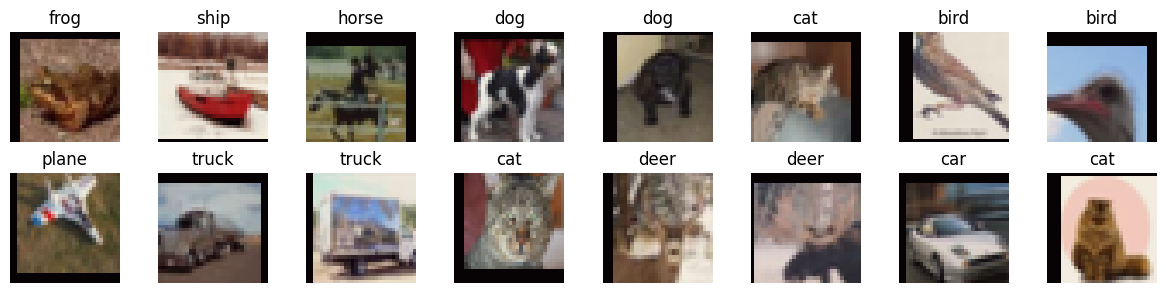

In [8]:
show_cifar_images(dataset=datasets['train'], grid_size=(2, 8), show_labels=True)

# to show images with predictions:
# show_cifar_images((2, 8), show_labels=True, dataset=testset, preds=preds)

## ResNet preview

In [ ]:
resnet18 = resnet("resnet18", num_classes=10)

# load resnet18 pretrained on ImageNet
# resnet18_torch = torchvision.models.resnet.resnet18(num_classes=10)

print(f"Number of parameters: {count_parameters(resnet18, print_table=False)/1e6 :.3f} M")
print(f"Parameter in MB: {calculate_storage_in_mb(resnet18):.3f}")
print(f"Number of expected layers: {resnet18.expected_layers()}")
# print(f"Number of FLOPS: {count_FLOPS(resnet18, input_dim=(32, 32))/1e9:.3f} GFLOPS")

# dummy_input = torch.randn(16, 3, 32, 32)
# dummy_output = resnet18(dummy_input)

del(resnet18)

## Training Manager

In [5]:
class TrainingManager:
    def __init__(self, config, datasets):
        self.datasets = datasets
        self.config = config

        self._load()

    def _load(self) -> None:
        # read config
        self.dataset = self.config.get("dataset", "CIFAR10")
        self.classes = get_dataset_classes(self.dataset)
        self.num_classes = len(self.classes)
        self.T = self.config.get("T", 10)
        self.batch_size = self.config.get("batch_size", 16)
        self.input_dim = self.config.get("input_dim", (32, 32))
        self.total_epochs = self.config.get("total_epochs", 100)
        self.weight_decay = self.config.get("weight_decay", 1e-4)
        self.baseline_lr = self.config.get("lr", 1e-4)
        self.patience = self.config.get("patience", 20)
        self.track_metrics = self.config.get("track_metrics", ["loss"])
        self.num_classes = self.config.get("num_classes", 10)

        # initiate dataloader
        self.dataloaders = {
            "train": DataLoader(
                self.datasets["train"], batch_size=self.batch_size, shuffle=True
            ),
            "val": DataLoader(
                self.datasets["val"], batch_size=self.batch_size, shuffle=False
            ),
            "test": DataLoader(
                self.datasets["test"], batch_size=self.batch_size, shuffle=False
            ),
        }

        # initiate model
        self.net = resnet(
            resnet_name=self.config["model"],
            num_classes=self.config.get("num_classes", 10),
            dropout_mode=self.config.get("dropout_mode", "none"),
            dropout_p=self.config.get("dropout_p", 0.0),
            sd_mode=self.config.get("sd_mode", "none"),
            sd_p=self.config.get("sd_p", 0.0),
        )
        self.net.to(DEVICE)

        # initiate loss function and metric
        self.criterion = parse_loss(self.config.get("loss", "CE"))
        self.metric = AccuracyMetric(metrics=["acc"], classes=self.classes)

        # initiate optimizer and scheduler
        self.optimizer = parse_optimizer(
            self.net,
            self.config.get("optimizer", "sgd"),
            self.baseline_lr,
            self.weight_decay,
            momentum = self.config.get("momentum", 0.9)
        )

        self.scheduler = parse_scheduler(
            self.optimizer,
            self.config.get("scheduler", "none"),
            self.total_epochs,
            milestones=self.config.get("milestones", None),
            gamma=self.config.get("gamma", None),
        )

        # initialize history
        self.epoch = 0
        self.history = {"lr": []}

        for split in ["train", "val", "val_b"]:
            self.history[f"loss/{split}"] = []
            self.history[f"acc/avg/{split}"] = []
            self.history[f"acc/global/{split}"] = []
            for c in self.classes:
                self.history[f"acc/{c}/{split}"] = []

        self.history["best_val_loss"] = 999
        self.history["best_val_acc"] = 0
        self.history["best_epoch"] = 0
        self.patience_count = 0

    def _check_early_stop(self, min_epochs: int = 10) -> bool:
        """
        Checks for early stop and updates best net, returns early stop state
        """
        if self.epoch < min_epochs or len(self.history["loss/val"]) <= 1:
            return False

        update_best = False
        loss = self.history["loss/val"][-1]
        acc = self.history["acc/avg/val"][-1]
        curr_min_loss = self.history.get("best_val_loss", 999)
        curr_max_acc = self.history.get("best_val_acc", 0)

        # compare loss and acc to current best
        if "loss" in self.track_metrics and loss < curr_min_loss:
            print(f"loss decreased by {(curr_min_loss-loss)/curr_min_loss*100 :.3f} %")
            self.history["best_val_loss"] = loss
            update_best = True
        if "acc" in self.track_metrics and acc > curr_max_acc:
            print(
                f"acc increased by {(acc-curr_max_acc)/(curr_max_acc+1e-16)*100 :.3f} %"
            )
            self.history["best_val_acc"] = acc
            update_best = True

        if loss > curr_min_loss and acc < curr_max_acc:
            self.patience_count += 1

        # update best net
        if update_best:
            print("saving best net...")
            self.best_net = copy.deepcopy(self.net)
            self.history["best_epoch"] = self.epoch
            self.patience_count = 0

        if self.patience_count >= self.patience:
            print(
                f"Acc(c) or miou have not improved for {self.patience} epochs, terminate training"
            )
            return True

        return False

    def evaluate(
        self,
        set: str = "test",
        bayes_mode: bool = False,
        T: Optional[int] = None,
        **kwargs,
    ) -> Tuple[float, Dict[str, float]]:
        """
        Evaluate the model on a given set
        """
        self.net.eval()  # must be called before setting bayes mode
        if bayes_mode:
            self.net.set_bayes_mode(True)
            T = self.T if T is None else T
            assert T > 0, "T must be greater than 0 if bayes_mode is True"

            h, w = self.config["input_dim"]
            buffer_tensor = torch.empty(
                size=(T, 3, h, w), dtype=torch.float32, device=DEVICE
            )
        else:
            self.net.set_bayes_mode(False)
            T = 0
            buffer_tensor = None

        loss = 0
        confusion_matrix = torch.zeros(
            (self.num_classes, self.num_classes), device=DEVICE
        )

        with torch.no_grad():
            for X_batch, y_batch in tqdm(self.dataloaders[set]):
                if bayes_mode:
                    # force batch size to be 1
                    for x, y in zip(X_batch, y_batch):
                        # forward pass
                        y_logits, y_pred = bayes_eval(
                            self.net, x, T, buffer=buffer_tensor
                        )
                        # compute loss
                        loss += self.criterion(y, y_logits).item()
                        # update confusion matrix
                        confusion_matrix += get_confusion_matrix(
                            y, y_pred, self.num_classes
                        )
                elif not bayes_mode:
                    # regular forward pass over the batch
                    batch_size = len(X_batch)
                    # forward pass
                    y_logits = self.net(X_batch)
                    # compute loss
                    loss += self.criterion(y_batch, y_logits).item() * batch_size
                    # update confusion matrix
                    y_pred = torch.argmax(y_logits, 1, keepdim=False)
                    confusion_matrix += get_confusion_matrix(
                        y_batch, y_pred, self.num_classes
                    )

        # compute loss and accuracy
        loss /= len(self.dataloaders[set].dataset)
        accs = self.metric(confusion_matrix)

        return loss, accs

    def train(self, epochs, eval_mode="bayes") -> None:
        """
        Main training loop
        Args:
            epochs: number of epochs to train
            eval_mode: mode to evaluate the model, can be "regular", "bayes", or "all"
        """
        torch.cuda.empty_cache()  # helps clearing RAM
        for e in range(epochs):
            self.net.train()
            # stochastic regularization should always be on during training
            self.net.set_bayes_mode(True)
            # create temporary dict to hold epoch results for train set
            train_loss = 0
            confusion_matrix = torch.zeros(
                (self.num_classes, self.num_classes), device=DEVICE
            )

            for X_batch, y_batch in tqdm(self.dataloaders["train"]):
                self.optimizer.zero_grad()
                # forward pass
                y_logits = self.net(X_batch)
                # compute loss
                loss = self.criterion(y_batch, y_logits)
                # back prop
                loss.backward()
                # update parameters
                self.optimizer.step()
                # update loss
                batch_size = X_batch.shape[0]
                train_loss += loss.item() * batch_size
                # update confusion matrix
                y_pred = torch.argmax(y_logits, 1, keepdim=False)
                confusion_matrix += get_confusion_matrix(
                    y_batch, y_pred, self.num_classes
                )
            self.scheduler.step()

            # compute average train loss and accuracy
            n_train = len(self.dataloaders["train"].dataset)
            train_loss /= n_train
            accs = self.metric(confusion_matrix)
            self._log_history("train", train_loss, accs)

            # compute validation loss and accuracy
            val_loss, val_accs, val_loss_b, val_accs_b = None, None, None, None
            if eval_mode == "regular" or eval_mode == "all":
                val_loss, val_accs = self.evaluate("val", bayes_mode=False)
            if eval_mode == "bayes" or eval_mode == "all":
                val_loss_b, val_accs_b = self.evaluate("val", bayes_mode=True)

            self._log_history("val", val_loss, val_accs)
            self._log_history("val_b", val_loss_b, val_accs_b)

            self.history["lr"].append(self.scheduler.get_last_lr()[0])

            # check for early stop
            early_stop = self._check_early_stop()
            self.epoch += 1

            # print results
            print(f"Epoch {self.epoch}")
            for name in ["train", "val"]:
                print(
                    f"{name}: Acc(g) = {self.history[f'acc/global/{name}'][-1]*100:.4f}, Acc(c) = {self.history[f'acc/avg/{name}'][-1]*100:.4f}, Loss = {self.history[f'loss/{name}'][-1]:.4f}"
                )

            if early_stop or self.epoch >= self.total_epochs:
                print("Terminate training")
                return

    def _log_history(self, set: str, loss: float, accs: Dict[str, float]) -> None:
        loss = loss if loss is not None else 0
        accs = accs if accs is not None else {}
        self.history[f"loss/{set}"].append(loss)
        for name in accs.keys():
            self.history[f"{name}/{set}"].append(accs.get(name, 0))
        return

    def load(self, dir: str) -> None:
        """
        Load a model from a given directory
        """
        net_path = os.path.join(dir, "model.pt")
        best_net_path = os.path.join(dir, "best_model.pt")
        history_path = os.path.join(dir, "history.json")
        config_path = os.path.join(dir, "config.json")

        if not os.path.exists(history_path):
            raise ValueError(f"Could not find history at {history_path}")
        if not os.path.exists(config_path):
            raise ValueError(f"Could not find config at {config_path}")

        with open(history_path, "r") as f:
            self.history = json.load(f)
        with open(config_path, "r") as f:
            self.config = json.load(f)

        self._load()

        if not os.path.exists(net_path):
            raise ValueError(f"Could not find model at {net_path}")
        self.net = torch.load(net_path).to(self.device)

        if not os.path.exists(best_net_path):
            self.best_net = None
        else:
            self.best_net = torch.load(best_net_path).to(self.device)

        print(f"Loaded model from {dir}")

## Result Manager

In [6]:
from visualization import (
    plot_loss_history,
    plot_acc_history,
    plot_per_class_acc_history,
)
from utils import get_dataset_classes, compute_calibration_errors, _get_calibration, _compute_calibration_statistics
import json


class ResultManager:
    def __init__(
        self,
        training_manager: TrainingManager,
        directory: Optional[str] = None,
    ) -> None:
        self.training_manager = training_manager
        self.datasets = training_manager.datasets
        self.config = training_manager.config

        dataset_name = self.training_manager.config["dataset"]
        self.classes = get_dataset_classes(dataset_name)

        if directory is None:
            experiment = self.training_manager.config["experiment"]
            self.directory = f"results/{dataset_name}/{experiment}"
        else:
            self.directory = directory

    def save(self, **kwargs) -> None:
        """
        Saves the training results to self.directory
        """
        self._save_history(kwargs.pop("save_plot", True))
        self._save_config()
        self._save_net(kwargs.pop("save_best_net", False))
        self._save_results()
        self._save_calibration(
            num_buckets=kwargs.pop("num_buckets", 10),
            ks=kwargs.pop("ks", None),
            save_plot=kwargs.pop("save_plot", False),
        )

        return

    def _save_history(self, save_plot=True) -> None:
        """
        Saves the training history to self.directory/history.json
        """
        history = self.training_manager.history
        with open(f"{self.directory}/history.json", "w") as f:
            json.dump(history, f, indent=2)
        print(f"saved history to {self.directory}/history.json")
        if save_plot:
            self.plot_history(history, save=True)

    def _save_config(self) -> None:
        """
        Saves the training config to self.directory/config.json
        """
        config = self.training_manager.config
        with open(f"{self.directory}/config.json", "w") as f:
            json.dump(config, f, indent=2)
        print(f"saved config to {self.directory}/config.json")

    def _save_net(self, save_best_net=False) -> None:
        """
        Saves the trained model to self.directory/net.pt
        """
        net = self.training_manager.net
        torch.save(net.state_dict(), f"{self.directory}/model.pt")
        if save_best_net:
            best_net = self.training_manager.best_net
            torch.save(best_net.state_dict(), f"{self.directory}/best_model.pt")
        print(f"saved net to {self.directory}/net.pt")

    def _save_results(self) -> None:
        """
        Runs evaluation on test set, then saves the results to self.directory/results.json
        """
        # Retrieve information about training and validation set from history
        results = {}
        history = self.training_manager.history
        for split in ["train", "val"]:
            results[split] = {}
            for metric in ["loss", "acc/avg", "acc/global"]:
                results[split][metric] = history[f"{metric}/{split}"][-1]
            results[split]["acc"] = {}
            for c in self.classes:
                results[split]["acc"][f"{c}"] = history[f"acc/{c}/{split}"][-1]

        # Test set
        print("Evaluating on test set...")
        loss, accs = self.training_manager.evaluate("test", bayes_mode=False)
        loss_b, accs_b = self.training_manager.evaluate("test", bayes_mode=True)

        results["test"] = {
            "loss": loss,
            "acc/global": accs["acc/global"],
            "acc/avg": accs["acc/avg"],
            "accs": {},
        }
        results["test_bayes"] = {
            "loss": loss_b,
            "acc/global": accs_b["acc/global"],
            "acc/avg": accs_b["acc/avg"],
            "accs": {},
        }
        for c in self.classes:
            results["test"]["accs"][c] = accs[f"acc/{c}"]
            results["test_bayes"]["accs"][c] = accs_b[f"acc/{c}"]

        with open(f"{self.directory}/results.json", "w") as f:
            json.dump(results, f, indent=2)
        print(f"saved results to {self.directory}/results.json")

    def _save_calibration(
        self,
        num_buckets: Optional[int] = 10,
        ks: Optional[List[int]] = None,
        save_plot: Optional[bool] = False,
    ) -> None:
        self.plot_calibration(num_buckets, ks, save_json=True, save_plot=save_plot)

        # ECE, MCE = compute_calibration_errors(net, self.datasets["test"], )

    def plot_calibration(
        self,
        num_buckets: Optional[int] = 10,
        ks: Optional[List[int]] = None,  # include 0 for normal pass
        save_json: bool = False,
        save_plot: bool = False,
        dataloader: Optional[DataLoader] = None,
        net: Optional[nn.Module] = None,
    ) -> None:
        if ks is None:
            ks = [0, 5, 10]

        if dataloader is None:
            dataloader = self.training_manager.dataloaders["test"]

        if net is None:
            net = self.training_manager.net

        statistics = {}

        plt.figure(figsize=(8, 6))

        linear_line = np.array(range(num_buckets + 1)) / (num_buckets)
        plt.plot(linear_line, linear_line, color="black", zorder=2)

        print(f"computing calibration for k={ks}")
        for i, k in enumerate(ks):
            # get the buckets
            total_counts, total_corrects, confs = _get_calibration(
                net, dataloader, k=k, num_buckets=num_buckets
            )
            # compute statistics
            ECE, MCE = _compute_calibration_statistics(total_counts, total_corrects, confs)
            statistics[k] = {"MCE": float(MCE), "ECE": float(ECE)}
            # calculate the accuracy of each bucket
            acc = total_corrects / total_counts

            plt.plot(confs, acc, label=f"k={k}, ECE={ECE:.3f}")

        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.xlabel("Confidence")
        plt.ylabel("Accuracy")

        plt.legend()

        if save_json:
            filepath = os.path.join(self.directory, "calibration.json")
            with open(filepath, "w") as f:
                json.dump(statistics, f, indent=2)
                print(f"saved to {filepath}")

        if save_plot:
            filepath = os.path.join(self.directory, "calibration.png")
            plt.savefig(filepath, dpi=200)
            print(f"saved to {filepath}")

        return statistics

    def plot_history(
        self,
        history: Optional[Dict] = None,
        classes: List[str] = None,
        save: bool = False,
    ) -> None:
        """
        Plots the training history
        ------------------------------
        Loss trainval | acc(g) trainval
        ------------------------------
        acc(c) train  | acc(c) val
        ------------------------------
        """
        if history is None:
            history = self.training_manager.history

        if classes is None:
            classes = self.classes

        assert [
            x in history.keys()
            for x in ["loss/train", "loss/val", "acc/global/train", "acc/global/val"]
        ], "history does not contain the required keys"

        plt.figure(figsize=(12, 10))
        plt.subplot(2, 2, 1)
        loss_history = {"train": history["loss/train"], "val": history["loss/val"]}
        plot_loss_history(loss_history)
        plt.title("Loss")

        plt.subplot(2, 2, 2)
        acc_history = {
            "train": history["acc/global/train"],
            "val": history["acc/global/val"],
        }
        plot_acc_history(acc_history)
        plt.title("Acc(g)")

        plt.subplot(2, 2, 3)
        per_class_acc_history = {cls: history[f"acc/{cls}/train"] for cls in classes}
        plot_per_class_acc_history(per_class_acc_history, classes)
        plt.title("Acc(c) Train")

        plt.subplot(2, 2, 4)
        per_class_acc_history = {cls: history[f"acc/{cls}/val"] for cls in classes}
        plot_per_class_acc_history(per_class_acc_history, classes)
        plt.title("Acc(c) Val")

        plt.tight_layout()

        if save:
            plt.savefig(f"{self.directory}/history.png", dpi=200)
            print(f"saved history to {self.directory}/history.png")

## Training

In [8]:
# TODO: refactor into utils
def _create_experiment_dir(
    config: Dict[str, Any], root_dir: str = "/content/drive/MyDrive/Bayes-Stochastic-Depth"
) -> str:
    dataset = config.get("dataset", "cifar10")
    result_dir = f"{root_dir}/results/{dataset}/"
    exp = config["experiment"]

    experiment_dir = os.path.join(result_dir, exp)

    if exp not in os.listdir(result_dir):
        os.mkdir(experiment_dir)
        print(f"created directory {experiment_dir}")
    else:
        num_items = len(os.listdir(experiment_dir))
        if num_items > 0:
            print("Warning: duplicate experiment name!")
            print(
                f"Directory at {experiment_dir} already exists and contains {num_items} items"
            )

    return experiment_dir

In [11]:
config = {
    "experiment": "resnet18_300e_classifier",
    "dataset": "cifar10",  # from which we get classes separately
    "input_dim": (32, 32),
    "model": "resnet18",
    "dropout_mode": "classifier",
    "dropout_p": 0.5,
    "sd_mode": "none",
    "sd_p": 0.0,
    "loss": "CE",  # ["CE", "Focal"]
    "optimizer": "sgd",
    "lr": 0.1,
    "weight_decay": 1e-4,
    "scheduler": "multistep",  # ["poly", "exp", "multistep"],
    "milestones": [150, 225],
    "gamma": 0.1,
    "T": 10,
    "batch_size": 256,
    "total_epochs": 300,
    "patience": 300,
    "track_metrics": ["loss", "acc"],
}

training_manager = TrainingManager(config, datasets)
result_manager = ResultManager(training_manager, _create_experiment_dir(config))

created directory /content/drive/MyDrive/Bayes-Stochastic-Depth/results/cifar10/resnet18_300e_classifier


100%|██████████| 20/20 [00:00<00:00, 84.39it/s]


Epoch 1
train: Acc(g) = 35.4556, Acc(c) = 35.4398, Loss = 2.0972
val: Acc(g) = 43.4600, Acc(c) = 43.7496, Loss = 1.7264


100%|██████████| 20/20 [00:00<00:00, 88.50it/s]


Epoch 2
train: Acc(g) = 50.9933, Acc(c) = 50.9779, Loss = 1.3895
val: Acc(g) = 54.7600, Acc(c) = 54.7438, Loss = 1.2993


100%|██████████| 20/20 [00:00<00:00, 88.21it/s]


Epoch 3
train: Acc(g) = 59.9022, Acc(c) = 59.8878, Loss = 1.1324
val: Acc(g) = 60.8800, Acc(c) = 60.9484, Loss = 1.1096


100%|██████████| 20/20 [00:00<00:00, 91.19it/s]


Epoch 4
train: Acc(g) = 66.7889, Acc(c) = 66.7757, Loss = 0.9363
val: Acc(g) = 65.0600, Acc(c) = 65.2274, Loss = 1.0022


100%|██████████| 20/20 [00:00<00:00, 91.58it/s]


Epoch 5
train: Acc(g) = 71.8511, Acc(c) = 71.8389, Loss = 0.7955
val: Acc(g) = 67.5400, Acc(c) = 67.5987, Loss = 0.9362


100%|██████████| 20/20 [00:00<00:00, 89.86it/s]


Epoch 6
train: Acc(g) = 75.8111, Acc(c) = 75.8001, Loss = 0.6868
val: Acc(g) = 69.4400, Acc(c) = 69.4848, Loss = 0.8974


100%|██████████| 20/20 [00:00<00:00, 53.43it/s]


Epoch 7
train: Acc(g) = 79.1822, Acc(c) = 79.1729, Loss = 0.5876
val: Acc(g) = 66.5400, Acc(c) = 66.7928, Loss = 1.0263


100%|██████████| 20/20 [00:00<00:00, 89.69it/s]


Epoch 8
train: Acc(g) = 82.1867, Acc(c) = 82.1772, Loss = 0.5053
val: Acc(g) = 71.4800, Acc(c) = 71.5867, Loss = 0.8882


100%|██████████| 20/20 [00:00<00:00, 80.79it/s]


Epoch 9
train: Acc(g) = 85.0044, Acc(c) = 84.9981, Loss = 0.4220
val: Acc(g) = 70.3800, Acc(c) = 70.5065, Loss = 0.9284


100%|██████████| 20/20 [00:00<00:00, 88.85it/s]


Epoch 10
train: Acc(g) = 87.4311, Acc(c) = 87.4240, Loss = 0.3563
val: Acc(g) = 71.0400, Acc(c) = 71.1318, Loss = 0.9787


100%|██████████| 20/20 [00:00<00:00, 85.65it/s]


loss decreased by 99.897 %
acc increased by 715499341487884544.000 %
saving best net...
Epoch 11
train: Acc(g) = 89.6378, Acc(c) = 89.6329, Loss = 0.2906
val: Acc(g) = 71.5200, Acc(c) = 71.5499, Loss = 1.0305


100%|██████████| 20/20 [00:00<00:00, 89.59it/s]


Epoch 12
train: Acc(g) = 91.4156, Acc(c) = 91.4110, Loss = 0.2435
val: Acc(g) = 70.9800, Acc(c) = 71.0025, Loss = 1.0684


100%|██████████| 20/20 [00:00<00:00, 88.57it/s]


Epoch 13
train: Acc(g) = 92.6600, Acc(c) = 92.6569, Loss = 0.2111
val: Acc(g) = 70.7200, Acc(c) = 70.8117, Loss = 1.1787


100%|██████████| 20/20 [00:00<00:00, 86.57it/s]


acc increased by 2.483 %
saving best net...
Epoch 14
train: Acc(g) = 93.7111, Acc(c) = 93.7074, Loss = 0.1792
val: Acc(g) = 73.3200, Acc(c) = 73.3263, Loss = 1.0925


100%|██████████| 20/20 [00:00<00:00, 89.27it/s]


Epoch 15
train: Acc(g) = 94.4933, Acc(c) = 94.4903, Loss = 0.1553
val: Acc(g) = 72.1400, Acc(c) = 72.1489, Loss = 1.2251


100%|██████████| 20/20 [00:00<00:00, 81.43it/s]


Epoch 16
train: Acc(g) = 95.0422, Acc(c) = 95.0395, Loss = 0.1401
val: Acc(g) = 71.9000, Acc(c) = 71.9153, Loss = 1.1664


100%|██████████| 20/20 [00:00<00:00, 89.70it/s]


Epoch 17
train: Acc(g) = 95.9200, Acc(c) = 95.9179, Loss = 0.1160
val: Acc(g) = 71.8800, Acc(c) = 71.9549, Loss = 1.2955


100%|██████████| 20/20 [00:00<00:00, 81.83it/s]


Epoch 18
train: Acc(g) = 96.1756, Acc(c) = 96.1739, Loss = 0.1112
val: Acc(g) = 71.7800, Acc(c) = 71.9149, Loss = 1.2538


100%|██████████| 20/20 [00:00<00:00, 91.08it/s]


Epoch 19
train: Acc(g) = 96.6111, Acc(c) = 96.6096, Loss = 0.0948
val: Acc(g) = 71.8800, Acc(c) = 71.9419, Loss = 1.2524


100%|██████████| 20/20 [00:00<00:00, 81.30it/s]


Epoch 20
train: Acc(g) = 97.0156, Acc(c) = 97.0146, Loss = 0.0867
val: Acc(g) = 72.1600, Acc(c) = 72.3133, Loss = 1.3710


100%|██████████| 20/20 [00:00<00:00, 89.94it/s]


Epoch 21
train: Acc(g) = 96.7600, Acc(c) = 96.7585, Loss = 0.0916
val: Acc(g) = 71.9600, Acc(c) = 72.0542, Loss = 1.3163


100%|██████████| 20/20 [00:00<00:00, 90.00it/s]


Epoch 22
train: Acc(g) = 97.0733, Acc(c) = 97.0723, Loss = 0.0822
val: Acc(g) = 71.3400, Acc(c) = 71.3630, Loss = 1.4291


100%|██████████| 20/20 [00:00<00:00, 91.64it/s]


Epoch 23
train: Acc(g) = 97.3556, Acc(c) = 97.3542, Loss = 0.0776
val: Acc(g) = 72.5200, Acc(c) = 72.6252, Loss = 1.3533


100%|██████████| 20/20 [00:00<00:00, 89.57it/s]


Epoch 24
train: Acc(g) = 97.5444, Acc(c) = 97.5429, Loss = 0.0677
val: Acc(g) = 72.7000, Acc(c) = 72.6764, Loss = 1.3938


100%|██████████| 20/20 [00:00<00:00, 89.19it/s]


Epoch 25
train: Acc(g) = 97.9956, Acc(c) = 97.9944, Loss = 0.0588
val: Acc(g) = 72.9200, Acc(c) = 73.0473, Loss = 1.4699


100%|██████████| 20/20 [00:00<00:00, 89.67it/s]


acc increased by 0.196 %
saving best net...
Epoch 26
train: Acc(g) = 97.8444, Acc(c) = 97.8436, Loss = 0.0638
val: Acc(g) = 73.3800, Acc(c) = 73.4702, Loss = 1.4151


100%|██████████| 20/20 [00:00<00:00, 81.24it/s]


Epoch 27
train: Acc(g) = 98.0267, Acc(c) = 98.0256, Loss = 0.0583
val: Acc(g) = 72.7800, Acc(c) = 72.8272, Loss = 1.3385


100%|██████████| 20/20 [00:00<00:00, 86.25it/s]


Epoch 28
train: Acc(g) = 98.1800, Acc(c) = 98.1791, Loss = 0.0543
val: Acc(g) = 73.0400, Acc(c) = 73.1237, Loss = 1.3664


100%|██████████| 20/20 [00:00<00:00, 82.23it/s]


Epoch 29
train: Acc(g) = 97.6556, Acc(c) = 97.6549, Loss = 0.0667
val: Acc(g) = 73.2800, Acc(c) = 73.3625, Loss = 1.3713


100%|██████████| 20/20 [00:00<00:00, 89.96it/s]


Epoch 30
train: Acc(g) = 97.6711, Acc(c) = 97.6705, Loss = 0.0671
val: Acc(g) = 72.5400, Acc(c) = 72.6356, Loss = 1.3496


100%|██████████| 20/20 [00:00<00:00, 91.02it/s]


acc increased by 0.057 %
saving best net...
Epoch 31
train: Acc(g) = 98.1933, Acc(c) = 98.1925, Loss = 0.0523
val: Acc(g) = 73.4600, Acc(c) = 73.5118, Loss = 1.4246


100%|██████████| 20/20 [00:00<00:00, 89.41it/s]


Epoch 32
train: Acc(g) = 98.0622, Acc(c) = 98.0615, Loss = 0.0567
val: Acc(g) = 72.0000, Acc(c) = 72.0385, Loss = 1.4552


100%|██████████| 20/20 [00:00<00:00, 91.28it/s]


Epoch 33
train: Acc(g) = 98.5044, Acc(c) = 98.5041, Loss = 0.0445
val: Acc(g) = 73.1200, Acc(c) = 73.1816, Loss = 1.4838


100%|██████████| 20/20 [00:00<00:00, 91.35it/s]


Epoch 34
train: Acc(g) = 98.1422, Acc(c) = 98.1415, Loss = 0.0522
val: Acc(g) = 73.3800, Acc(c) = 73.4320, Loss = 1.3802


100%|██████████| 20/20 [00:00<00:00, 91.33it/s]


Epoch 35
train: Acc(g) = 98.5044, Acc(c) = 98.5042, Loss = 0.0424
val: Acc(g) = 72.5800, Acc(c) = 72.7083, Loss = 1.5695


100%|██████████| 20/20 [00:00<00:00, 81.31it/s]


acc increased by 0.152 %
saving best net...
Epoch 36
train: Acc(g) = 98.5822, Acc(c) = 98.5813, Loss = 0.0417
val: Acc(g) = 73.5600, Acc(c) = 73.6232, Loss = 1.4353


100%|██████████| 20/20 [00:00<00:00, 90.89it/s]


Epoch 37
train: Acc(g) = 98.2844, Acc(c) = 98.2836, Loss = 0.0501
val: Acc(g) = 73.3400, Acc(c) = 73.3977, Loss = 1.3403


100%|██████████| 20/20 [00:00<00:00, 81.17it/s]


acc increased by 0.135 %
saving best net...
Epoch 38
train: Acc(g) = 98.6778, Acc(c) = 98.6770, Loss = 0.0398
val: Acc(g) = 73.6400, Acc(c) = 73.7226, Loss = 1.3918


100%|██████████| 20/20 [00:00<00:00, 91.62it/s]


Epoch 39
train: Acc(g) = 98.6289, Acc(c) = 98.6283, Loss = 0.0416
val: Acc(g) = 73.2600, Acc(c) = 73.3301, Loss = 1.4547


100%|██████████| 20/20 [00:00<00:00, 82.14it/s]


Epoch 40
train: Acc(g) = 98.4911, Acc(c) = 98.4908, Loss = 0.0445
val: Acc(g) = 72.7600, Acc(c) = 72.8851, Loss = 1.5219


100%|██████████| 20/20 [00:00<00:00, 91.33it/s]


Epoch 41
train: Acc(g) = 98.6467, Acc(c) = 98.6460, Loss = 0.0395
val: Acc(g) = 73.0200, Acc(c) = 73.1784, Loss = 1.4997


100%|██████████| 20/20 [00:00<00:00, 90.27it/s]


Epoch 42
train: Acc(g) = 98.4133, Acc(c) = 98.4132, Loss = 0.0462
val: Acc(g) = 73.5200, Acc(c) = 73.6586, Loss = 1.3922


100%|██████████| 20/20 [00:00<00:00, 90.52it/s]


Epoch 43
train: Acc(g) = 98.5022, Acc(c) = 98.5018, Loss = 0.0433
val: Acc(g) = 71.4600, Acc(c) = 71.5694, Loss = 1.5644


100%|██████████| 20/20 [00:00<00:00, 89.46it/s]


Epoch 44
train: Acc(g) = 98.4556, Acc(c) = 98.4551, Loss = 0.0450
val: Acc(g) = 73.4000, Acc(c) = 73.4844, Loss = 1.4071


100%|██████████| 20/20 [00:00<00:00, 89.70it/s]


Epoch 45
train: Acc(g) = 98.7400, Acc(c) = 98.7397, Loss = 0.0358
val: Acc(g) = 73.2800, Acc(c) = 73.3586, Loss = 1.5275


100%|██████████| 20/20 [00:00<00:00, 87.09it/s]


acc increased by 0.011 %
saving best net...
Epoch 46
train: Acc(g) = 98.7689, Acc(c) = 98.7684, Loss = 0.0363
val: Acc(g) = 73.6800, Acc(c) = 73.7310, Loss = 1.4652


100%|██████████| 20/20 [00:00<00:00, 81.15it/s]


Epoch 47
train: Acc(g) = 98.3533, Acc(c) = 98.3522, Loss = 0.0480
val: Acc(g) = 73.0400, Acc(c) = 73.1228, Loss = 1.4413


100%|██████████| 20/20 [00:00<00:00, 62.60it/s]


Epoch 48
train: Acc(g) = 98.8511, Acc(c) = 98.8505, Loss = 0.0339
val: Acc(g) = 73.1600, Acc(c) = 73.2222, Loss = 1.4988


100%|██████████| 20/20 [00:00<00:00, 79.27it/s]


Epoch 49
train: Acc(g) = 98.5867, Acc(c) = 98.5863, Loss = 0.0413
val: Acc(g) = 72.4000, Acc(c) = 72.5040, Loss = 1.4751


100%|██████████| 20/20 [00:00<00:00, 89.66it/s]


Epoch 50
train: Acc(g) = 98.3689, Acc(c) = 98.3689, Loss = 0.0458
val: Acc(g) = 72.6200, Acc(c) = 72.6966, Loss = 1.4706


100%|██████████| 20/20 [00:00<00:00, 87.16it/s]


acc increased by 0.236 %
saving best net...
Epoch 51
train: Acc(g) = 98.6622, Acc(c) = 98.6617, Loss = 0.0402
val: Acc(g) = 73.7800, Acc(c) = 73.9047, Loss = 1.4800


100%|██████████| 20/20 [00:00<00:00, 89.33it/s]


Epoch 52
train: Acc(g) = 98.4111, Acc(c) = 98.4108, Loss = 0.0459
val: Acc(g) = 72.3600, Acc(c) = 72.4891, Loss = 1.4963


100%|██████████| 20/20 [00:00<00:00, 88.79it/s]


Epoch 53
train: Acc(g) = 98.4689, Acc(c) = 98.4686, Loss = 0.0443
val: Acc(g) = 73.0600, Acc(c) = 73.1878, Loss = 1.4267


100%|██████████| 20/20 [00:00<00:00, 90.02it/s]


Epoch 54
train: Acc(g) = 98.5733, Acc(c) = 98.5728, Loss = 0.0410
val: Acc(g) = 73.8000, Acc(c) = 73.8641, Loss = 1.4196


100%|██████████| 20/20 [00:00<00:00, 92.14it/s]


acc increased by 0.034 %
saving best net...
Epoch 55
train: Acc(g) = 98.5756, Acc(c) = 98.5749, Loss = 0.0412
val: Acc(g) = 73.8600, Acc(c) = 73.9297, Loss = 1.3435


100%|██████████| 20/20 [00:00<00:00, 81.00it/s]


Epoch 56
train: Acc(g) = 98.6556, Acc(c) = 98.6550, Loss = 0.0389
val: Acc(g) = 72.8800, Acc(c) = 72.9783, Loss = 1.4024


100%|██████████| 20/20 [00:00<00:00, 89.62it/s]


acc increased by 0.575 %
saving best net...
Epoch 57
train: Acc(g) = 98.8289, Acc(c) = 98.8289, Loss = 0.0358
val: Acc(g) = 74.2800, Acc(c) = 74.3546, Loss = 1.4134


100%|██████████| 20/20 [00:00<00:00, 83.57it/s]


Epoch 58
train: Acc(g) = 98.9333, Acc(c) = 98.9331, Loss = 0.0320
val: Acc(g) = 72.0800, Acc(c) = 72.1548, Loss = 1.5181


100%|██████████| 20/20 [00:00<00:00, 91.39it/s]


acc increased by 0.512 %
saving best net...
Epoch 59
train: Acc(g) = 98.7756, Acc(c) = 98.7755, Loss = 0.0352
val: Acc(g) = 74.6600, Acc(c) = 74.7354, Loss = 1.3934


100%|██████████| 20/20 [00:00<00:00, 79.83it/s]


Epoch 60
train: Acc(g) = 99.0000, Acc(c) = 98.9998, Loss = 0.0285
val: Acc(g) = 73.6000, Acc(c) = 73.6984, Loss = 1.4436


100%|██████████| 20/20 [00:00<00:00, 91.36it/s]


Epoch 61
train: Acc(g) = 98.8178, Acc(c) = 98.8174, Loss = 0.0348
val: Acc(g) = 72.8600, Acc(c) = 72.9833, Loss = 1.4391


100%|██████████| 20/20 [00:00<00:00, 90.67it/s]


Epoch 62
train: Acc(g) = 98.2822, Acc(c) = 98.2813, Loss = 0.0478
val: Acc(g) = 73.6800, Acc(c) = 73.7356, Loss = 1.3619


100%|██████████| 20/20 [00:00<00:00, 91.15it/s]


Epoch 63
train: Acc(g) = 98.6867, Acc(c) = 98.6862, Loss = 0.0379
val: Acc(g) = 74.4000, Acc(c) = 74.4768, Loss = 1.4328


100%|██████████| 20/20 [00:00<00:00, 90.58it/s]


Epoch 64
train: Acc(g) = 98.8978, Acc(c) = 98.8977, Loss = 0.0332
val: Acc(g) = 73.1400, Acc(c) = 73.2176, Loss = 1.5076


100%|██████████| 20/20 [00:00<00:00, 83.58it/s]


Epoch 65
train: Acc(g) = 98.6600, Acc(c) = 98.6597, Loss = 0.0391
val: Acc(g) = 73.1800, Acc(c) = 73.2776, Loss = 1.4038


100%|██████████| 20/20 [00:00<00:00, 91.75it/s]


Epoch 66
train: Acc(g) = 99.0267, Acc(c) = 99.0261, Loss = 0.0297
val: Acc(g) = 73.9400, Acc(c) = 74.0584, Loss = 1.4202


100%|██████████| 20/20 [00:00<00:00, 84.28it/s]


Epoch 67
train: Acc(g) = 98.7422, Acc(c) = 98.7414, Loss = 0.0394
val: Acc(g) = 72.2200, Acc(c) = 72.3260, Loss = 1.4729


100%|██████████| 20/20 [00:00<00:00, 89.11it/s]


Epoch 68
train: Acc(g) = 98.4844, Acc(c) = 98.4841, Loss = 0.0469
val: Acc(g) = 72.9600, Acc(c) = 73.0359, Loss = 1.3926


100%|██████████| 20/20 [00:00<00:00, 83.06it/s]


Epoch 69
train: Acc(g) = 98.5978, Acc(c) = 98.5972, Loss = 0.0420
val: Acc(g) = 73.4200, Acc(c) = 73.4953, Loss = 1.4102


100%|██████████| 20/20 [00:00<00:00, 91.17it/s]


Epoch 70
train: Acc(g) = 98.8378, Acc(c) = 98.8375, Loss = 0.0335
val: Acc(g) = 72.9600, Acc(c) = 73.0885, Loss = 1.4540


100%|██████████| 20/20 [00:00<00:00, 92.64it/s]


Epoch 71
train: Acc(g) = 98.7600, Acc(c) = 98.7595, Loss = 0.0369
val: Acc(g) = 72.4800, Acc(c) = 72.4810, Loss = 1.4990


100%|██████████| 20/20 [00:00<00:00, 90.18it/s]


Epoch 72
train: Acc(g) = 98.4489, Acc(c) = 98.4486, Loss = 0.0451
val: Acc(g) = 73.8400, Acc(c) = 73.8599, Loss = 1.3668


100%|██████████| 20/20 [00:00<00:00, 90.50it/s]


Epoch 73
train: Acc(g) = 98.5644, Acc(c) = 98.5641, Loss = 0.0429
val: Acc(g) = 73.2000, Acc(c) = 73.3319, Loss = 1.4346


100%|██████████| 20/20 [00:00<00:00, 89.88it/s]


Epoch 74
train: Acc(g) = 98.5667, Acc(c) = 98.5666, Loss = 0.0396
val: Acc(g) = 71.0600, Acc(c) = 71.0676, Loss = 1.4787


100%|██████████| 20/20 [00:00<00:00, 91.45it/s]


Epoch 75
train: Acc(g) = 98.5800, Acc(c) = 98.5793, Loss = 0.0434
val: Acc(g) = 73.2400, Acc(c) = 73.3422, Loss = 1.3846


100%|██████████| 20/20 [00:00<00:00, 84.92it/s]


Epoch 76
train: Acc(g) = 99.0578, Acc(c) = 99.0573, Loss = 0.0284
val: Acc(g) = 73.1000, Acc(c) = 73.1785, Loss = 1.4539


100%|██████████| 20/20 [00:00<00:00, 90.29it/s]


Epoch 77
train: Acc(g) = 98.8156, Acc(c) = 98.8153, Loss = 0.0356
val: Acc(g) = 73.7200, Acc(c) = 73.7665, Loss = 1.3592


100%|██████████| 20/20 [00:00<00:00, 81.31it/s]


Epoch 78
train: Acc(g) = 98.9333, Acc(c) = 98.9330, Loss = 0.0303
val: Acc(g) = 73.7200, Acc(c) = 73.8109, Loss = 1.4523


100%|██████████| 20/20 [00:00<00:00, 90.21it/s]


Epoch 79
train: Acc(g) = 98.9400, Acc(c) = 98.9398, Loss = 0.0309
val: Acc(g) = 73.7000, Acc(c) = 73.8228, Loss = 1.4344


100%|██████████| 20/20 [00:00<00:00, 81.59it/s]


Epoch 80
train: Acc(g) = 98.6444, Acc(c) = 98.6443, Loss = 0.0406
val: Acc(g) = 72.9200, Acc(c) = 73.0261, Loss = 1.4117


100%|██████████| 20/20 [00:00<00:00, 63.71it/s]


Epoch 81
train: Acc(g) = 98.5578, Acc(c) = 98.5571, Loss = 0.0413
val: Acc(g) = 73.8200, Acc(c) = 73.8706, Loss = 1.3497


100%|██████████| 20/20 [00:00<00:00, 90.31it/s]


acc increased by 0.693 %
saving best net...
Epoch 82
train: Acc(g) = 99.1022, Acc(c) = 99.1018, Loss = 0.0262
val: Acc(g) = 75.1400, Acc(c) = 75.2531, Loss = 1.3894


100%|██████████| 20/20 [00:00<00:00, 88.64it/s]


Epoch 83
train: Acc(g) = 98.7956, Acc(c) = 98.7953, Loss = 0.0341
val: Acc(g) = 73.0400, Acc(c) = 73.1003, Loss = 1.4197


100%|██████████| 20/20 [00:00<00:00, 90.81it/s]


Epoch 84
train: Acc(g) = 98.3200, Acc(c) = 98.3195, Loss = 0.0485
val: Acc(g) = 72.8000, Acc(c) = 72.9132, Loss = 1.4303


100%|██████████| 20/20 [00:00<00:00, 82.99it/s]


Epoch 85
train: Acc(g) = 98.7311, Acc(c) = 98.7307, Loss = 0.0362
val: Acc(g) = 73.5800, Acc(c) = 73.6704, Loss = 1.3707


100%|██████████| 20/20 [00:00<00:00, 91.59it/s]


Epoch 86
train: Acc(g) = 98.6778, Acc(c) = 98.6777, Loss = 0.0393
val: Acc(g) = 73.9200, Acc(c) = 74.0969, Loss = 1.4318


100%|██████████| 20/20 [00:00<00:00, 81.72it/s]


Epoch 87
train: Acc(g) = 98.9844, Acc(c) = 98.9840, Loss = 0.0301
val: Acc(g) = 73.3400, Acc(c) = 73.4194, Loss = 1.3940


100%|██████████| 20/20 [00:00<00:00, 91.18it/s]


Epoch 88
train: Acc(g) = 98.8822, Acc(c) = 98.8816, Loss = 0.0328
val: Acc(g) = 71.6400, Acc(c) = 71.6753, Loss = 1.5001


100%|██████████| 20/20 [00:00<00:00, 79.91it/s]


Epoch 89
train: Acc(g) = 98.5022, Acc(c) = 98.5014, Loss = 0.0430
val: Acc(g) = 72.1600, Acc(c) = 72.2900, Loss = 1.4394


100%|██████████| 20/20 [00:00<00:00, 91.76it/s]


Epoch 90
train: Acc(g) = 98.5178, Acc(c) = 98.5175, Loss = 0.0442
val: Acc(g) = 74.1400, Acc(c) = 74.1926, Loss = 1.3254


100%|██████████| 20/20 [00:00<00:00, 91.30it/s]


Epoch 91
train: Acc(g) = 98.7667, Acc(c) = 98.7663, Loss = 0.0352
val: Acc(g) = 73.8400, Acc(c) = 73.9091, Loss = 1.3613


100%|██████████| 20/20 [00:00<00:00, 90.22it/s]


Epoch 92
train: Acc(g) = 98.8956, Acc(c) = 98.8952, Loss = 0.0320
val: Acc(g) = 72.9600, Acc(c) = 72.9552, Loss = 1.4263


100%|██████████| 20/20 [00:00<00:00, 89.95it/s]


Epoch 93
train: Acc(g) = 98.9111, Acc(c) = 98.9107, Loss = 0.0317
val: Acc(g) = 73.7000, Acc(c) = 73.7394, Loss = 1.4319


100%|██████████| 20/20 [00:00<00:00, 89.70it/s]


Epoch 94
train: Acc(g) = 98.9022, Acc(c) = 98.9023, Loss = 0.0325
val: Acc(g) = 72.3400, Acc(c) = 72.3952, Loss = 1.4498


100%|██████████| 20/20 [00:00<00:00, 89.97it/s]


Epoch 95
train: Acc(g) = 98.7622, Acc(c) = 98.7619, Loss = 0.0362
val: Acc(g) = 72.9800, Acc(c) = 73.0615, Loss = 1.4382


100%|██████████| 20/20 [00:00<00:00, 80.50it/s]


Epoch 96
train: Acc(g) = 98.4956, Acc(c) = 98.4951, Loss = 0.0431
val: Acc(g) = 72.3200, Acc(c) = 72.4260, Loss = 1.4709


100%|██████████| 20/20 [00:00<00:00, 90.50it/s]


Epoch 97
train: Acc(g) = 98.6911, Acc(c) = 98.6904, Loss = 0.0394
val: Acc(g) = 74.1200, Acc(c) = 74.1791, Loss = 1.3196


100%|██████████| 20/20 [00:00<00:00, 83.09it/s]


Epoch 98
train: Acc(g) = 98.7756, Acc(c) = 98.7750, Loss = 0.0353
val: Acc(g) = 72.9800, Acc(c) = 73.0942, Loss = 1.4185


100%|██████████| 20/20 [00:00<00:00, 89.76it/s]


Epoch 99
train: Acc(g) = 98.8267, Acc(c) = 98.8266, Loss = 0.0341
val: Acc(g) = 72.8000, Acc(c) = 72.8332, Loss = 1.4270


100%|██████████| 20/20 [00:00<00:00, 80.98it/s]


Epoch 100
train: Acc(g) = 98.7111, Acc(c) = 98.7105, Loss = 0.0373
val: Acc(g) = 73.2400, Acc(c) = 73.3228, Loss = 1.4269


100%|██████████| 20/20 [00:00<00:00, 90.50it/s]


Epoch 101
train: Acc(g) = 98.5356, Acc(c) = 98.5351, Loss = 0.0424
val: Acc(g) = 72.7800, Acc(c) = 72.9032, Loss = 1.3855


100%|██████████| 20/20 [00:00<00:00, 90.39it/s]


Epoch 102
train: Acc(g) = 99.0378, Acc(c) = 99.0372, Loss = 0.0294
val: Acc(g) = 73.6600, Acc(c) = 73.6281, Loss = 1.3849


100%|██████████| 20/20 [00:00<00:00, 89.41it/s]


Epoch 103
train: Acc(g) = 98.5978, Acc(c) = 98.5974, Loss = 0.0399
val: Acc(g) = 73.0800, Acc(c) = 73.1329, Loss = 1.3842


100%|██████████| 20/20 [00:00<00:00, 90.88it/s]


Epoch 104
train: Acc(g) = 99.0644, Acc(c) = 99.0641, Loss = 0.0282
val: Acc(g) = 74.7200, Acc(c) = 74.8091, Loss = 1.3513


100%|██████████| 20/20 [00:00<00:00, 92.03it/s]


Epoch 105
train: Acc(g) = 98.7467, Acc(c) = 98.7464, Loss = 0.0358
val: Acc(g) = 73.5800, Acc(c) = 73.5978, Loss = 1.3708


100%|██████████| 20/20 [00:00<00:00, 65.12it/s]


Epoch 106
train: Acc(g) = 99.0200, Acc(c) = 99.0197, Loss = 0.0300
val: Acc(g) = 72.7200, Acc(c) = 72.7258, Loss = 1.4317


100%|██████████| 20/20 [00:00<00:00, 83.03it/s]


Epoch 107
train: Acc(g) = 98.6933, Acc(c) = 98.6931, Loss = 0.0395
val: Acc(g) = 73.5400, Acc(c) = 73.6148, Loss = 1.3598


100%|██████████| 20/20 [00:00<00:00, 89.84it/s]


Epoch 108
train: Acc(g) = 98.6622, Acc(c) = 98.6618, Loss = 0.0392
val: Acc(g) = 73.3000, Acc(c) = 73.3806, Loss = 1.4060


100%|██████████| 20/20 [00:00<00:00, 81.89it/s]


Epoch 109
train: Acc(g) = 98.8578, Acc(c) = 98.8577, Loss = 0.0338
val: Acc(g) = 74.5200, Acc(c) = 74.6318, Loss = 1.3506


100%|██████████| 20/20 [00:00<00:00, 90.75it/s]


Epoch 110
train: Acc(g) = 99.1511, Acc(c) = 99.1506, Loss = 0.0252
val: Acc(g) = 73.2200, Acc(c) = 73.3119, Loss = 1.4094


100%|██████████| 20/20 [00:00<00:00, 90.97it/s]


Epoch 111
train: Acc(g) = 99.0111, Acc(c) = 99.0107, Loss = 0.0299
val: Acc(g) = 72.2800, Acc(c) = 72.3520, Loss = 1.4626


100%|██████████| 20/20 [00:00<00:00, 90.41it/s]


Epoch 112
train: Acc(g) = 98.7289, Acc(c) = 98.7287, Loss = 0.0380
val: Acc(g) = 72.8600, Acc(c) = 72.8977, Loss = 1.4393


100%|██████████| 20/20 [00:00<00:00, 89.67it/s]


Epoch 113
train: Acc(g) = 98.8511, Acc(c) = 98.8504, Loss = 0.0347
val: Acc(g) = 72.8800, Acc(c) = 72.9401, Loss = 1.3979


100%|██████████| 20/20 [00:00<00:00, 91.08it/s]


Epoch 114
train: Acc(g) = 98.7667, Acc(c) = 98.7663, Loss = 0.0365
val: Acc(g) = 73.0400, Acc(c) = 73.0953, Loss = 1.3883


100%|██████████| 20/20 [00:00<00:00, 92.40it/s]


Epoch 115
train: Acc(g) = 98.5156, Acc(c) = 98.5152, Loss = 0.0425
val: Acc(g) = 72.8000, Acc(c) = 72.9160, Loss = 1.3704


100%|██████████| 20/20 [00:00<00:00, 81.07it/s]


Epoch 116
train: Acc(g) = 98.5356, Acc(c) = 98.5352, Loss = 0.0420
val: Acc(g) = 73.1400, Acc(c) = 73.2362, Loss = 1.3471


100%|██████████| 20/20 [00:00<00:00, 92.44it/s]


Epoch 117
train: Acc(g) = 99.0667, Acc(c) = 99.0663, Loss = 0.0289
val: Acc(g) = 73.0600, Acc(c) = 73.1100, Loss = 1.3797


100%|██████████| 20/20 [00:00<00:00, 81.36it/s]


Epoch 118
train: Acc(g) = 99.1178, Acc(c) = 99.1176, Loss = 0.0268
val: Acc(g) = 72.7600, Acc(c) = 72.8615, Loss = 1.4088


100%|██████████| 20/20 [00:00<00:00, 91.91it/s]


Epoch 119
train: Acc(g) = 99.0533, Acc(c) = 99.0530, Loss = 0.0292
val: Acc(g) = 73.5400, Acc(c) = 73.5609, Loss = 1.3641


100%|██████████| 20/20 [00:00<00:00, 81.49it/s]


Epoch 120
train: Acc(g) = 98.5689, Acc(c) = 98.5684, Loss = 0.0415
val: Acc(g) = 73.4600, Acc(c) = 73.5385, Loss = 1.4001


100%|██████████| 20/20 [00:00<00:00, 91.35it/s]


Epoch 121
train: Acc(g) = 98.7889, Acc(c) = 98.7881, Loss = 0.0358
val: Acc(g) = 73.2400, Acc(c) = 73.3691, Loss = 1.3504


100%|██████████| 20/20 [00:00<00:00, 90.14it/s]


Epoch 122
train: Acc(g) = 98.9267, Acc(c) = 98.9265, Loss = 0.0323
val: Acc(g) = 73.8400, Acc(c) = 73.9646, Loss = 1.3322


100%|██████████| 20/20 [00:00<00:00, 89.61it/s]


Epoch 123
train: Acc(g) = 98.8911, Acc(c) = 98.8908, Loss = 0.0319
val: Acc(g) = 73.6000, Acc(c) = 73.7184, Loss = 1.3913


100%|██████████| 20/20 [00:00<00:00, 91.13it/s]


Epoch 124
train: Acc(g) = 98.8089, Acc(c) = 98.8086, Loss = 0.0359
val: Acc(g) = 73.3400, Acc(c) = 73.4417, Loss = 1.3589


100%|██████████| 20/20 [00:00<00:00, 90.98it/s]


Epoch 125
train: Acc(g) = 98.9133, Acc(c) = 98.9125, Loss = 0.0328
val: Acc(g) = 74.0800, Acc(c) = 74.0910, Loss = 1.3346


100%|██████████| 20/20 [00:00<00:00, 88.67it/s]


Epoch 126
train: Acc(g) = 99.0333, Acc(c) = 99.0332, Loss = 0.0295
val: Acc(g) = 73.7200, Acc(c) = 73.8002, Loss = 1.3312


100%|██████████| 20/20 [00:00<00:00, 82.93it/s]


Epoch 127
train: Acc(g) = 98.6800, Acc(c) = 98.6795, Loss = 0.0371
val: Acc(g) = 73.3600, Acc(c) = 73.4417, Loss = 1.3836


100%|██████████| 20/20 [00:00<00:00, 92.09it/s]


Epoch 128
train: Acc(g) = 98.5222, Acc(c) = 98.5216, Loss = 0.0420
val: Acc(g) = 72.5000, Acc(c) = 72.6025, Loss = 1.3721


100%|██████████| 20/20 [00:00<00:00, 80.23it/s]


Epoch 129
train: Acc(g) = 98.4489, Acc(c) = 98.4484, Loss = 0.0449
val: Acc(g) = 73.6600, Acc(c) = 73.7237, Loss = 1.3561


100%|██████████| 20/20 [00:00<00:00, 90.39it/s]


Epoch 130
train: Acc(g) = 98.6156, Acc(c) = 98.6153, Loss = 0.0381
val: Acc(g) = 73.7600, Acc(c) = 73.7860, Loss = 1.3777


100%|██████████| 20/20 [00:00<00:00, 55.21it/s]


Epoch 131
train: Acc(g) = 98.8511, Acc(c) = 98.8505, Loss = 0.0355
val: Acc(g) = 74.3000, Acc(c) = 74.3646, Loss = 1.3791


100%|██████████| 20/20 [00:00<00:00, 89.52it/s]


Epoch 132
train: Acc(g) = 98.9956, Acc(c) = 98.9950, Loss = 0.0317
val: Acc(g) = 73.5000, Acc(c) = 73.5779, Loss = 1.3588


100%|██████████| 20/20 [00:00<00:00, 91.26it/s]


Epoch 133
train: Acc(g) = 98.8333, Acc(c) = 98.8332, Loss = 0.0335
val: Acc(g) = 74.6400, Acc(c) = 74.7217, Loss = 1.3794


100%|██████████| 20/20 [00:00<00:00, 90.62it/s]


Epoch 134
train: Acc(g) = 99.2089, Acc(c) = 99.2087, Loss = 0.0228
val: Acc(g) = 73.9200, Acc(c) = 73.9982, Loss = 1.4342


100%|██████████| 20/20 [00:00<00:00, 88.75it/s]


Epoch 135
train: Acc(g) = 98.7511, Acc(c) = 98.7503, Loss = 0.0360
val: Acc(g) = 74.2200, Acc(c) = 74.2487, Loss = 1.3451


100%|██████████| 20/20 [00:00<00:00, 89.23it/s]


Epoch 136
train: Acc(g) = 98.5067, Acc(c) = 98.5061, Loss = 0.0433
val: Acc(g) = 73.7000, Acc(c) = 73.7996, Loss = 1.3430


100%|██████████| 20/20 [00:00<00:00, 91.08it/s]


Epoch 137
train: Acc(g) = 98.9044, Acc(c) = 98.9044, Loss = 0.0321
val: Acc(g) = 74.5200, Acc(c) = 74.5807, Loss = 1.3544


100%|██████████| 20/20 [00:00<00:00, 79.26it/s]


Epoch 138
train: Acc(g) = 99.0756, Acc(c) = 99.0751, Loss = 0.0277
val: Acc(g) = 73.4200, Acc(c) = 73.5724, Loss = 1.4127


100%|██████████| 20/20 [00:00<00:00, 91.36it/s]


Epoch 139
train: Acc(g) = 98.8422, Acc(c) = 98.8421, Loss = 0.0336
val: Acc(g) = 73.4200, Acc(c) = 73.4640, Loss = 1.3748


100%|██████████| 20/20 [00:00<00:00, 84.02it/s]


Epoch 140
train: Acc(g) = 98.9978, Acc(c) = 98.9974, Loss = 0.0307
val: Acc(g) = 74.2000, Acc(c) = 74.2958, Loss = 1.3401


100%|██████████| 20/20 [00:00<00:00, 90.80it/s]


Epoch 141
train: Acc(g) = 99.2000, Acc(c) = 99.1996, Loss = 0.0241
val: Acc(g) = 73.4600, Acc(c) = 73.5224, Loss = 1.4267


100%|██████████| 20/20 [00:00<00:00, 90.97it/s]


Epoch 142
train: Acc(g) = 99.0556, Acc(c) = 99.0557, Loss = 0.0280
val: Acc(g) = 74.0000, Acc(c) = 74.0996, Loss = 1.4284


100%|██████████| 20/20 [00:00<00:00, 89.93it/s]


Epoch 143
train: Acc(g) = 98.9244, Acc(c) = 98.9241, Loss = 0.0334
val: Acc(g) = 73.5800, Acc(c) = 73.6757, Loss = 1.4357


100%|██████████| 20/20 [00:00<00:00, 89.37it/s]


Epoch 144
train: Acc(g) = 98.9089, Acc(c) = 98.9085, Loss = 0.0337
val: Acc(g) = 74.3400, Acc(c) = 74.4311, Loss = 1.3560


100%|██████████| 20/20 [00:00<00:00, 91.07it/s]


Epoch 145
train: Acc(g) = 98.6711, Acc(c) = 98.6704, Loss = 0.0379
val: Acc(g) = 73.6200, Acc(c) = 73.6421, Loss = 1.3613


100%|██████████| 20/20 [00:00<00:00, 90.89it/s]


Epoch 146
train: Acc(g) = 98.8133, Acc(c) = 98.8128, Loss = 0.0337
val: Acc(g) = 74.1200, Acc(c) = 74.1788, Loss = 1.3427


100%|██████████| 20/20 [00:00<00:00, 81.18it/s]


Epoch 147
train: Acc(g) = 98.9467, Acc(c) = 98.9466, Loss = 0.0302
val: Acc(g) = 73.9400, Acc(c) = 74.0810, Loss = 1.3952


100%|██████████| 20/20 [00:00<00:00, 91.37it/s]


Epoch 148
train: Acc(g) = 98.9822, Acc(c) = 98.9822, Loss = 0.0298
val: Acc(g) = 72.4600, Acc(c) = 72.4779, Loss = 1.4686


100%|██████████| 20/20 [00:00<00:00, 83.00it/s]


Epoch 149
train: Acc(g) = 98.8800, Acc(c) = 98.8798, Loss = 0.0323
val: Acc(g) = 72.7600, Acc(c) = 72.8640, Loss = 1.4612


100%|██████████| 20/20 [00:00<00:00, 90.00it/s]


Epoch 150
train: Acc(g) = 98.6600, Acc(c) = 98.6597, Loss = 0.0384
val: Acc(g) = 72.3200, Acc(c) = 72.4677, Loss = 1.4104


100%|██████████| 20/20 [00:00<00:00, 82.05it/s]


acc increased by 0.360 %
saving best net...
Epoch 151
train: Acc(g) = 99.5333, Acc(c) = 99.5331, Loss = 0.0145
val: Acc(g) = 75.4400, Acc(c) = 75.5238, Loss = 1.2266


100%|██████████| 20/20 [00:00<00:00, 90.42it/s]


acc increased by 0.044 %
saving best net...
Epoch 152
train: Acc(g) = 99.9778, Acc(c) = 99.9778, Loss = 0.0026
val: Acc(g) = 75.4800, Acc(c) = 75.5569, Loss = 1.2293


100%|██████████| 20/20 [00:00<00:00, 89.30it/s]


acc increased by 0.334 %
saving best net...
Epoch 153
train: Acc(g) = 99.9978, Acc(c) = 99.9978, Loss = 0.0017
val: Acc(g) = 75.7200, Acc(c) = 75.8093, Loss = 1.2305


100%|██████████| 20/20 [00:00<00:00, 91.16it/s]


acc increased by 0.058 %
saving best net...
Epoch 154
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0013
val: Acc(g) = 75.7800, Acc(c) = 75.8530, Loss = 1.2313


100%|██████████| 20/20 [00:00<00:00, 91.01it/s]


acc increased by 0.185 %
saving best net...
Epoch 155
train: Acc(g) = 99.9978, Acc(c) = 99.9978, Loss = 0.0011
val: Acc(g) = 75.9200, Acc(c) = 75.9935, Loss = 1.2316


100%|██████████| 20/20 [00:00<00:00, 90.07it/s]


Epoch 156
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0009
val: Acc(g) = 75.8400, Acc(c) = 75.9147, Loss = 1.2363


100%|██████████| 20/20 [00:00<00:00, 91.26it/s]


acc increased by 0.394 %
saving best net...
Epoch 157
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0009
val: Acc(g) = 76.2200, Acc(c) = 76.2931, Loss = 1.2402


100%|██████████| 20/20 [00:00<00:00, 83.44it/s]


Epoch 158
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0008
val: Acc(g) = 76.0000, Acc(c) = 76.0801, Loss = 1.2440


100%|██████████| 20/20 [00:00<00:00, 90.81it/s]


Epoch 159
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0007
val: Acc(g) = 76.1000, Acc(c) = 76.1725, Loss = 1.2443


100%|██████████| 20/20 [00:00<00:00, 82.49it/s]


Epoch 160
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0006
val: Acc(g) = 76.1000, Acc(c) = 76.1685, Loss = 1.2472


100%|██████████| 20/20 [00:00<00:00, 91.94it/s]


Epoch 161
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0006
val: Acc(g) = 76.1800, Acc(c) = 76.2448, Loss = 1.2436


100%|██████████| 20/20 [00:00<00:00, 84.93it/s]


Epoch 162
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0006
val: Acc(g) = 76.1800, Acc(c) = 76.2519, Loss = 1.2533


100%|██████████| 20/20 [00:00<00:00, 91.06it/s]


Epoch 163
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0006
val: Acc(g) = 76.0600, Acc(c) = 76.1222, Loss = 1.2483


100%|██████████| 20/20 [00:00<00:00, 91.30it/s]


acc increased by 0.100 %
saving best net...
Epoch 164
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0005
val: Acc(g) = 76.3000, Acc(c) = 76.3691, Loss = 1.2491


100%|██████████| 20/20 [00:00<00:00, 92.68it/s]


Epoch 165
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0005
val: Acc(g) = 76.1800, Acc(c) = 76.2435, Loss = 1.2529


100%|██████████| 20/20 [00:00<00:00, 91.70it/s]


Epoch 166
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0005
val: Acc(g) = 76.0800, Acc(c) = 76.1579, Loss = 1.2498


100%|██████████| 20/20 [00:00<00:00, 92.42it/s]


Epoch 167
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0004
val: Acc(g) = 76.1800, Acc(c) = 76.2466, Loss = 1.2518


100%|██████████| 20/20 [00:00<00:00, 90.99it/s]


Epoch 168
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0004
val: Acc(g) = 76.2600, Acc(c) = 76.3322, Loss = 1.2548


100%|██████████| 20/20 [00:00<00:00, 83.08it/s]


Epoch 169
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0004
val: Acc(g) = 76.1800, Acc(c) = 76.2557, Loss = 1.2557


100%|██████████| 20/20 [00:00<00:00, 91.76it/s]


acc increased by 0.085 %
saving best net...
Epoch 170
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0004
val: Acc(g) = 76.3600, Acc(c) = 76.4341, Loss = 1.2534


100%|██████████| 20/20 [00:00<00:00, 84.13it/s]


Epoch 171
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0004
val: Acc(g) = 76.3200, Acc(c) = 76.3906, Loss = 1.2539


100%|██████████| 20/20 [00:00<00:00, 90.22it/s]


Epoch 172
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0004
val: Acc(g) = 76.3400, Acc(c) = 76.4067, Loss = 1.2587


100%|██████████| 20/20 [00:00<00:00, 81.09it/s]


Epoch 173
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0004
val: Acc(g) = 76.3200, Acc(c) = 76.3922, Loss = 1.2526


100%|██████████| 20/20 [00:00<00:00, 91.52it/s]


Epoch 174
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0004
val: Acc(g) = 76.1800, Acc(c) = 76.2520, Loss = 1.2592


100%|██████████| 20/20 [00:00<00:00, 91.94it/s]


Epoch 175
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0003
val: Acc(g) = 76.2800, Acc(c) = 76.3467, Loss = 1.2569


100%|██████████| 20/20 [00:00<00:00, 91.26it/s]


Epoch 176
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0003
val: Acc(g) = 76.3200, Acc(c) = 76.3934, Loss = 1.2580


100%|██████████| 20/20 [00:00<00:00, 91.12it/s]


acc increased by 0.055 %
saving best net...
Epoch 177
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0003
val: Acc(g) = 76.4000, Acc(c) = 76.4760, Loss = 1.2570


100%|██████████| 20/20 [00:00<00:00, 88.68it/s]


acc increased by 0.085 %
saving best net...
Epoch 178
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0003
val: Acc(g) = 76.4800, Acc(c) = 76.5407, Loss = 1.2556


100%|██████████| 20/20 [00:00<00:00, 91.41it/s]


Epoch 179
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0003
val: Acc(g) = 76.3600, Acc(c) = 76.4275, Loss = 1.2563


100%|██████████| 20/20 [00:00<00:00, 83.53it/s]


Epoch 180
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0003
val: Acc(g) = 76.3400, Acc(c) = 76.4126, Loss = 1.2552


100%|██████████| 20/20 [00:00<00:00, 89.13it/s]


acc increased by 0.111 %
saving best net...
Epoch 181
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0003
val: Acc(g) = 76.5600, Acc(c) = 76.6257, Loss = 1.2584


100%|██████████| 20/20 [00:00<00:00, 81.28it/s]


Epoch 182
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0003
val: Acc(g) = 76.3800, Acc(c) = 76.4578, Loss = 1.2582


100%|██████████| 20/20 [00:00<00:00, 91.85it/s]


Epoch 183
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0003
val: Acc(g) = 76.4800, Acc(c) = 76.5623, Loss = 1.2550


100%|██████████| 20/20 [00:00<00:00, 82.01it/s]


Epoch 184
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0003
val: Acc(g) = 76.3000, Acc(c) = 76.3673, Loss = 1.2538


100%|██████████| 20/20 [00:00<00:00, 90.39it/s]


Epoch 185
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0003
val: Acc(g) = 76.3600, Acc(c) = 76.4277, Loss = 1.2540


100%|██████████| 20/20 [00:00<00:00, 91.02it/s]


Epoch 186
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0003
val: Acc(g) = 76.4200, Acc(c) = 76.4931, Loss = 1.2564


100%|██████████| 20/20 [00:00<00:00, 90.65it/s]


Epoch 187
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0003
val: Acc(g) = 76.3800, Acc(c) = 76.4606, Loss = 1.2558


100%|██████████| 20/20 [00:00<00:00, 91.62it/s]


Epoch 188
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0003
val: Acc(g) = 76.3800, Acc(c) = 76.4522, Loss = 1.2500


100%|██████████| 20/20 [00:00<00:00, 89.88it/s]


Epoch 189
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0003
val: Acc(g) = 76.4000, Acc(c) = 76.4828, Loss = 1.2576


100%|██████████| 20/20 [00:00<00:00, 91.23it/s]


acc increased by 0.010 %
saving best net...
Epoch 190
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0003
val: Acc(g) = 76.5600, Acc(c) = 76.6332, Loss = 1.2561


100%|██████████| 20/20 [00:00<00:00, 81.91it/s]


Epoch 191
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0003
val: Acc(g) = 76.2200, Acc(c) = 76.2900, Loss = 1.2613


100%|██████████| 20/20 [00:00<00:00, 92.82it/s]


Epoch 192
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0003
val: Acc(g) = 76.3000, Acc(c) = 76.3624, Loss = 1.2511


100%|██████████| 20/20 [00:00<00:00, 84.89it/s]


Epoch 193
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.2400, Acc(c) = 76.3115, Loss = 1.2569


100%|██████████| 20/20 [00:00<00:00, 88.27it/s]


Epoch 194
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.2000, Acc(c) = 76.2694, Loss = 1.2541


100%|██████████| 20/20 [00:00<00:00, 80.14it/s]


Epoch 195
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4400, Acc(c) = 76.5218, Loss = 1.2544


100%|██████████| 20/20 [00:00<00:00, 92.71it/s]


acc increased by 0.034 %
saving best net...
Epoch 196
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5800, Acc(c) = 76.6591, Loss = 1.2556


100%|██████████| 20/20 [00:00<00:00, 92.14it/s]


Epoch 197
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.3600, Acc(c) = 76.4374, Loss = 1.2468


100%|██████████| 20/20 [00:00<00:00, 89.53it/s]


Epoch 198
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4800, Acc(c) = 76.5529, Loss = 1.2473


100%|██████████| 20/20 [00:00<00:00, 92.09it/s]


Epoch 199
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4600, Acc(c) = 76.5381, Loss = 1.2513


100%|██████████| 20/20 [00:00<00:00, 92.37it/s]


Epoch 200
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5000, Acc(c) = 76.5741, Loss = 1.2477


100%|██████████| 20/20 [00:00<00:00, 90.71it/s]


Epoch 201
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4000, Acc(c) = 76.4776, Loss = 1.2475


100%|██████████| 20/20 [00:00<00:00, 83.43it/s]


Epoch 202
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4800, Acc(c) = 76.5518, Loss = 1.2515


100%|██████████| 20/20 [00:00<00:00, 91.99it/s]


Epoch 203
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4600, Acc(c) = 76.5358, Loss = 1.2480


100%|██████████| 20/20 [00:00<00:00, 80.84it/s]


Epoch 204
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.3000, Acc(c) = 76.3672, Loss = 1.2483


100%|██████████| 20/20 [00:00<00:00, 89.04it/s]


Epoch 205
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.2000, Acc(c) = 76.2846, Loss = 1.2499


100%|██████████| 20/20 [00:00<00:00, 83.87it/s]


acc increased by 0.026 %
saving best net...
Epoch 206
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.6000, Acc(c) = 76.6794, Loss = 1.2397


100%|██████████| 20/20 [00:00<00:00, 91.99it/s]


Epoch 207
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.3200, Acc(c) = 76.3923, Loss = 1.2468


100%|██████████| 20/20 [00:00<00:00, 88.13it/s]


Epoch 208
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5600, Acc(c) = 76.6291, Loss = 1.2373


100%|██████████| 20/20 [00:00<00:00, 92.03it/s]


Epoch 209
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4200, Acc(c) = 76.5069, Loss = 1.2460


100%|██████████| 20/20 [00:00<00:00, 92.92it/s]


Epoch 210
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.3800, Acc(c) = 76.4620, Loss = 1.2448


100%|██████████| 20/20 [00:00<00:00, 90.05it/s]


Epoch 211
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4000, Acc(c) = 76.4725, Loss = 1.2427


100%|██████████| 20/20 [00:00<00:00, 89.86it/s]


Epoch 212
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4600, Acc(c) = 76.5337, Loss = 1.2349


100%|██████████| 20/20 [00:00<00:00, 54.57it/s]


Epoch 213
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4400, Acc(c) = 76.5162, Loss = 1.2306


100%|██████████| 20/20 [00:00<00:00, 88.78it/s]


Epoch 214
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5200, Acc(c) = 76.5994, Loss = 1.2362


100%|██████████| 20/20 [00:00<00:00, 81.67it/s]


Epoch 215
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4200, Acc(c) = 76.5101, Loss = 1.2434


100%|██████████| 20/20 [00:00<00:00, 90.39it/s]


Epoch 216
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5200, Acc(c) = 76.6074, Loss = 1.2388


100%|██████████| 20/20 [00:00<00:00, 78.45it/s]


Epoch 217
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5600, Acc(c) = 76.6412, Loss = 1.2374


100%|██████████| 20/20 [00:00<00:00, 91.89it/s]


Epoch 218
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.3800, Acc(c) = 76.4662, Loss = 1.2345


100%|██████████| 20/20 [00:00<00:00, 91.43it/s]


Epoch 219
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.6000, Acc(c) = 76.6764, Loss = 1.2291


100%|██████████| 20/20 [00:00<00:00, 91.72it/s]


Epoch 220
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4800, Acc(c) = 76.5561, Loss = 1.2316


100%|██████████| 20/20 [00:00<00:00, 89.42it/s]


Epoch 221
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.3800, Acc(c) = 76.4629, Loss = 1.2387


100%|██████████| 20/20 [00:00<00:00, 91.93it/s]


Epoch 222
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4200, Acc(c) = 76.4996, Loss = 1.2367


100%|██████████| 20/20 [00:00<00:00, 89.53it/s]


Epoch 223
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4200, Acc(c) = 76.4926, Loss = 1.2335


100%|██████████| 20/20 [00:00<00:00, 79.82it/s]


Epoch 224
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5800, Acc(c) = 76.6638, Loss = 1.2289


100%|██████████| 20/20 [00:00<00:00, 90.62it/s]


Epoch 225
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.3600, Acc(c) = 76.4425, Loss = 1.2313


100%|██████████| 20/20 [00:00<00:00, 80.18it/s]


Epoch 226
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5000, Acc(c) = 76.5773, Loss = 1.2312


100%|██████████| 20/20 [00:00<00:00, 89.83it/s]


Epoch 227
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5000, Acc(c) = 76.5686, Loss = 1.2242


100%|██████████| 20/20 [00:00<00:00, 81.94it/s]


Epoch 228
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5400, Acc(c) = 76.6149, Loss = 1.2259


100%|██████████| 20/20 [00:00<00:00, 89.55it/s]


Epoch 229
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4400, Acc(c) = 76.5224, Loss = 1.2258


100%|██████████| 20/20 [00:00<00:00, 91.37it/s]


Epoch 230
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5800, Acc(c) = 76.6567, Loss = 1.2330


100%|██████████| 20/20 [00:00<00:00, 90.67it/s]


Epoch 231
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5200, Acc(c) = 76.5965, Loss = 1.2253


100%|██████████| 20/20 [00:00<00:00, 90.53it/s]


Epoch 232
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4400, Acc(c) = 76.5264, Loss = 1.2321


100%|██████████| 20/20 [00:00<00:00, 90.59it/s]


Epoch 233
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4800, Acc(c) = 76.5531, Loss = 1.2279


100%|██████████| 20/20 [00:00<00:00, 89.77it/s]


Epoch 234
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.3800, Acc(c) = 76.4671, Loss = 1.2279


100%|██████████| 20/20 [00:00<00:00, 78.70it/s]


Epoch 235
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.3400, Acc(c) = 76.4154, Loss = 1.2294


100%|██████████| 20/20 [00:00<00:00, 91.12it/s]


Epoch 236
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5000, Acc(c) = 76.5765, Loss = 1.2324


100%|██████████| 20/20 [00:00<00:00, 83.43it/s]


Epoch 237
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4400, Acc(c) = 76.5248, Loss = 1.2282


100%|██████████| 20/20 [00:00<00:00, 63.37it/s]


Epoch 238
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5000, Acc(c) = 76.5796, Loss = 1.2283


100%|██████████| 20/20 [00:00<00:00, 81.28it/s]


acc increased by 0.046 %
saving best net...
Epoch 239
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.6400, Acc(c) = 76.7148, Loss = 1.2302


100%|██████████| 20/20 [00:00<00:00, 91.32it/s]


Epoch 240
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5000, Acc(c) = 76.5754, Loss = 1.2225


100%|██████████| 20/20 [00:00<00:00, 90.71it/s]


Epoch 241
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5400, Acc(c) = 76.6221, Loss = 1.2305


100%|██████████| 20/20 [00:00<00:00, 64.25it/s]


Epoch 242
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4400, Acc(c) = 76.5181, Loss = 1.2244


100%|██████████| 20/20 [00:00<00:00, 90.52it/s]


Epoch 243
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.3800, Acc(c) = 76.4520, Loss = 1.2277


100%|██████████| 20/20 [00:00<00:00, 91.13it/s]


Epoch 244
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4800, Acc(c) = 76.5564, Loss = 1.2256


100%|██████████| 20/20 [00:00<00:00, 91.61it/s]


Epoch 245
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.3600, Acc(c) = 76.4408, Loss = 1.2331


100%|██████████| 20/20 [00:00<00:00, 83.88it/s]


Epoch 246
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4000, Acc(c) = 76.4757, Loss = 1.2256


100%|██████████| 20/20 [00:00<00:00, 89.87it/s]


Epoch 247
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5600, Acc(c) = 76.6319, Loss = 1.2227


100%|██████████| 20/20 [00:00<00:00, 79.81it/s]


Epoch 248
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5400, Acc(c) = 76.6166, Loss = 1.2219


100%|██████████| 20/20 [00:00<00:00, 89.49it/s]


Epoch 249
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5400, Acc(c) = 76.6184, Loss = 1.2339


100%|██████████| 20/20 [00:00<00:00, 79.59it/s]


Epoch 250
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.3000, Acc(c) = 76.3815, Loss = 1.2245


100%|██████████| 20/20 [00:00<00:00, 90.94it/s]


Epoch 251
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4800, Acc(c) = 76.5648, Loss = 1.2300


100%|██████████| 20/20 [00:00<00:00, 91.82it/s]


Epoch 252
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5200, Acc(c) = 76.5975, Loss = 1.2302


100%|██████████| 20/20 [00:00<00:00, 91.10it/s]


Epoch 253
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4600, Acc(c) = 76.5421, Loss = 1.2311


100%|██████████| 20/20 [00:00<00:00, 90.14it/s]


Epoch 254
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.6000, Acc(c) = 76.6844, Loss = 1.2333


100%|██████████| 20/20 [00:00<00:00, 90.48it/s]


Epoch 255
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5000, Acc(c) = 76.5768, Loss = 1.2250


100%|██████████| 20/20 [00:00<00:00, 88.31it/s]


Epoch 256
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.3200, Acc(c) = 76.4038, Loss = 1.2291


100%|██████████| 20/20 [00:00<00:00, 79.35it/s]


acc increased by 0.027 %
saving best net...
Epoch 257
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.6600, Acc(c) = 76.7352, Loss = 1.2298


100%|██████████| 20/20 [00:00<00:00, 90.90it/s]


Epoch 258
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5200, Acc(c) = 76.6016, Loss = 1.2255


100%|██████████| 20/20 [00:00<00:00, 78.51it/s]


Epoch 259
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5200, Acc(c) = 76.5964, Loss = 1.2241


100%|██████████| 20/20 [00:00<00:00, 92.11it/s]


Epoch 260
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4800, Acc(c) = 76.5545, Loss = 1.2246


100%|██████████| 20/20 [00:00<00:00, 83.10it/s]


Epoch 261
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5200, Acc(c) = 76.6038, Loss = 1.2303


100%|██████████| 20/20 [00:00<00:00, 91.80it/s]


Epoch 262
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4200, Acc(c) = 76.5045, Loss = 1.2258


100%|██████████| 20/20 [00:00<00:00, 88.46it/s]


Epoch 263
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5200, Acc(c) = 76.5943, Loss = 1.2284


100%|██████████| 20/20 [00:00<00:00, 90.83it/s]


Epoch 264
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5800, Acc(c) = 76.6548, Loss = 1.2276


100%|██████████| 20/20 [00:00<00:00, 91.24it/s]


Epoch 265
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4800, Acc(c) = 76.5530, Loss = 1.2239


100%|██████████| 20/20 [00:00<00:00, 89.66it/s]


Epoch 266
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4600, Acc(c) = 76.5420, Loss = 1.2270


100%|██████████| 20/20 [00:00<00:00, 65.57it/s]


Epoch 267
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.3600, Acc(c) = 76.4437, Loss = 1.2270


100%|██████████| 20/20 [00:00<00:00, 81.23it/s]


Epoch 268
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4600, Acc(c) = 76.5428, Loss = 1.2259


100%|██████████| 20/20 [00:00<00:00, 88.57it/s]


Epoch 269
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.3400, Acc(c) = 76.4206, Loss = 1.2223


100%|██████████| 20/20 [00:00<00:00, 82.79it/s]


Epoch 270
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4400, Acc(c) = 76.5173, Loss = 1.2293


100%|██████████| 20/20 [00:00<00:00, 89.69it/s]


Epoch 271
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4800, Acc(c) = 76.5656, Loss = 1.2240


100%|██████████| 20/20 [00:00<00:00, 79.63it/s]


Epoch 272
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5000, Acc(c) = 76.5875, Loss = 1.2291


100%|██████████| 20/20 [00:00<00:00, 92.47it/s]


Epoch 273
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5600, Acc(c) = 76.6349, Loss = 1.2292


100%|██████████| 20/20 [00:00<00:00, 91.91it/s]


Epoch 274
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.2800, Acc(c) = 76.3624, Loss = 1.2233


100%|██████████| 20/20 [00:00<00:00, 91.54it/s]


Epoch 275
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.6000, Acc(c) = 76.6800, Loss = 1.2282


100%|██████████| 20/20 [00:00<00:00, 88.62it/s]


Epoch 276
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5000, Acc(c) = 76.5797, Loss = 1.2239


100%|██████████| 20/20 [00:00<00:00, 90.87it/s]


Epoch 277
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5800, Acc(c) = 76.6589, Loss = 1.2223


100%|██████████| 20/20 [00:00<00:00, 90.64it/s]


Epoch 278
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.3600, Acc(c) = 76.4584, Loss = 1.2271


100%|██████████| 20/20 [00:00<00:00, 81.23it/s]


Epoch 279
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4400, Acc(c) = 76.5176, Loss = 1.2238


100%|██████████| 20/20 [00:00<00:00, 89.27it/s]


Epoch 280
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4400, Acc(c) = 76.5112, Loss = 1.2225


100%|██████████| 20/20 [00:00<00:00, 81.69it/s]


Epoch 281
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4400, Acc(c) = 76.5142, Loss = 1.2206


100%|██████████| 20/20 [00:00<00:00, 88.99it/s]


Epoch 282
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5800, Acc(c) = 76.6576, Loss = 1.2247


100%|██████████| 20/20 [00:00<00:00, 81.98it/s]


Epoch 283
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.3000, Acc(c) = 76.3829, Loss = 1.2257


100%|██████████| 20/20 [00:00<00:00, 88.68it/s]


Epoch 284
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5200, Acc(c) = 76.5915, Loss = 1.2262


100%|██████████| 20/20 [00:00<00:00, 90.07it/s]


Epoch 285
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5800, Acc(c) = 76.6542, Loss = 1.2251


100%|██████████| 20/20 [00:00<00:00, 90.22it/s]


Epoch 286
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4600, Acc(c) = 76.5348, Loss = 1.2256


100%|██████████| 20/20 [00:00<00:00, 90.54it/s]


Epoch 287
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5200, Acc(c) = 76.5963, Loss = 1.2280


100%|██████████| 20/20 [00:00<00:00, 89.01it/s]


acc increased by 0.082 %
saving best net...
Epoch 288
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.7200, Acc(c) = 76.7982, Loss = 1.2239


100%|██████████| 20/20 [00:00<00:00, 88.99it/s]


Epoch 289
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4800, Acc(c) = 76.5677, Loss = 1.2281


100%|██████████| 20/20 [00:00<00:00, 83.81it/s]


Epoch 290
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4600, Acc(c) = 76.5398, Loss = 1.2250


100%|██████████| 20/20 [00:00<00:00, 90.63it/s]


Epoch 291
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.6000, Acc(c) = 76.6770, Loss = 1.2263


100%|██████████| 20/20 [00:00<00:00, 80.50it/s]


Epoch 292
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4800, Acc(c) = 76.5586, Loss = 1.2274


100%|██████████| 20/20 [00:00<00:00, 90.39it/s]


Epoch 293
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.3800, Acc(c) = 76.4483, Loss = 1.2298


100%|██████████| 20/20 [00:00<00:00, 83.38it/s]


Epoch 294
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5000, Acc(c) = 76.5820, Loss = 1.2279


100%|██████████| 20/20 [00:00<00:00, 90.53it/s]


Epoch 295
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.2400, Acc(c) = 76.3357, Loss = 1.2257


100%|██████████| 20/20 [00:00<00:00, 63.62it/s]


Epoch 296
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.3800, Acc(c) = 76.4632, Loss = 1.2233


100%|██████████| 20/20 [00:00<00:00, 91.64it/s]


Epoch 297
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4200, Acc(c) = 76.4990, Loss = 1.2286


100%|██████████| 20/20 [00:00<00:00, 91.42it/s]


Epoch 298
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.5000, Acc(c) = 76.5803, Loss = 1.2246


100%|██████████| 20/20 [00:00<00:00, 89.79it/s]


Epoch 299
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.4200, Acc(c) = 76.5113, Loss = 1.2259


100%|██████████| 20/20 [00:00<00:00, 89.42it/s]


Epoch 300
train: Acc(g) = 100.0000, Acc(c) = 100.0000, Loss = 0.0002
val: Acc(g) = 76.3600, Acc(c) = 76.4359, Loss = 1.2181
Terminate training
saved history to /content/drive/MyDrive/Bayes-Stochastic-Depth/results/cifar10/resnet18_300e_classifier/history.json
saved history to /content/drive/MyDrive/Bayes-Stochastic-Depth/results/cifar10/resnet18_300e_classifier/history.png
saved config to /content/drive/MyDrive/Bayes-Stochastic-Depth/results/cifar10/resnet18_300e_classifier/config.json
saved net to /content/drive/MyDrive/Bayes-Stochastic-Depth/results/cifar10/resnet18_300e_classifier/net.pt
Evaluating on test set...


100%|██████████| 40/40 [00:42<00:00,  1.06s/it]


saved results to /content/drive/MyDrive/Bayes-Stochastic-Depth/results/cifar10/resnet18_300e_classifier/results.json
computing calibration for k=[10]


100%|██████████| 40/40 [00:57<00:00,  1.43s/it]


saved to /content/drive/MyDrive/Bayes-Stochastic-Depth/results/cifar10/resnet18_300e_classifier/calibration.json


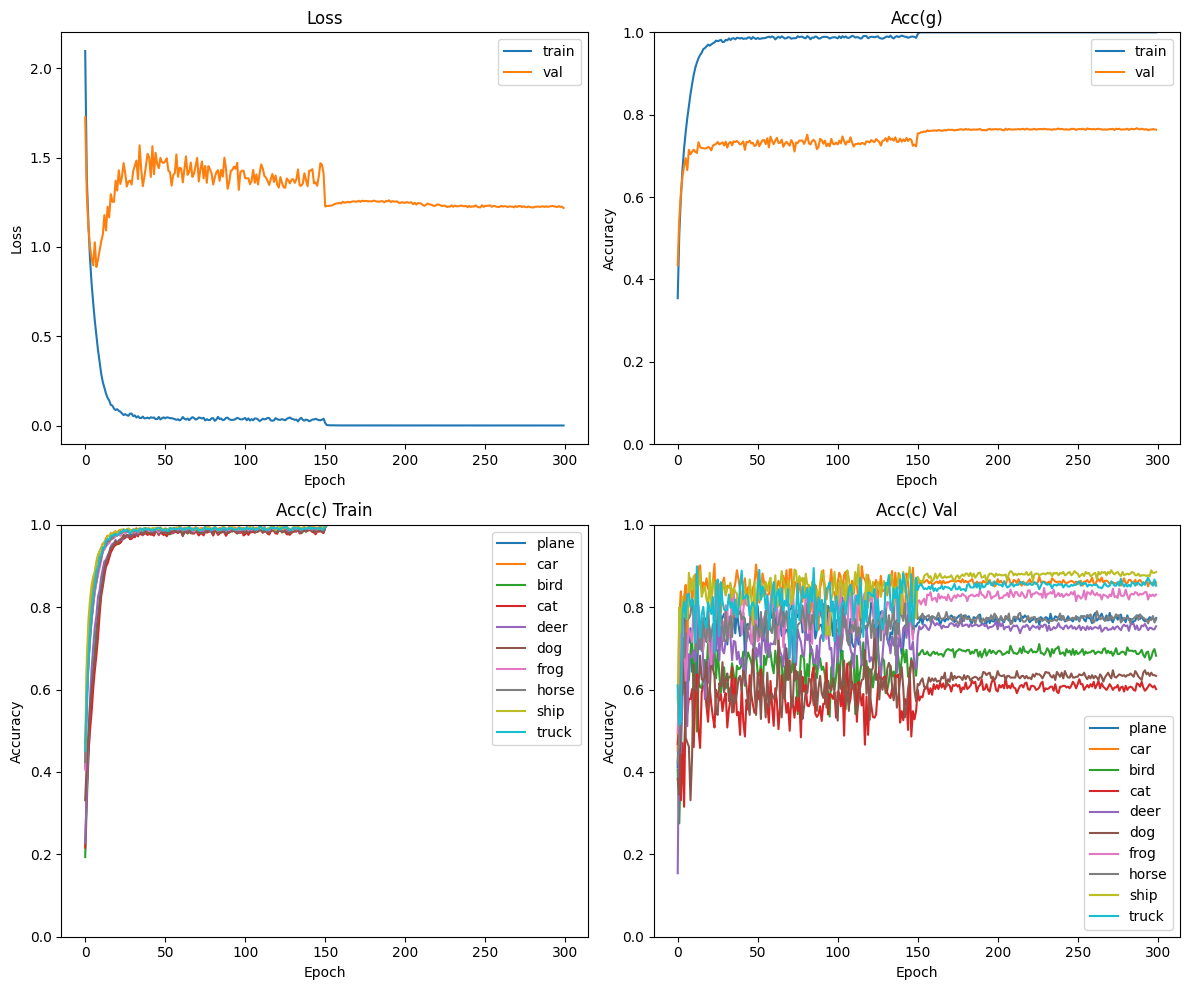

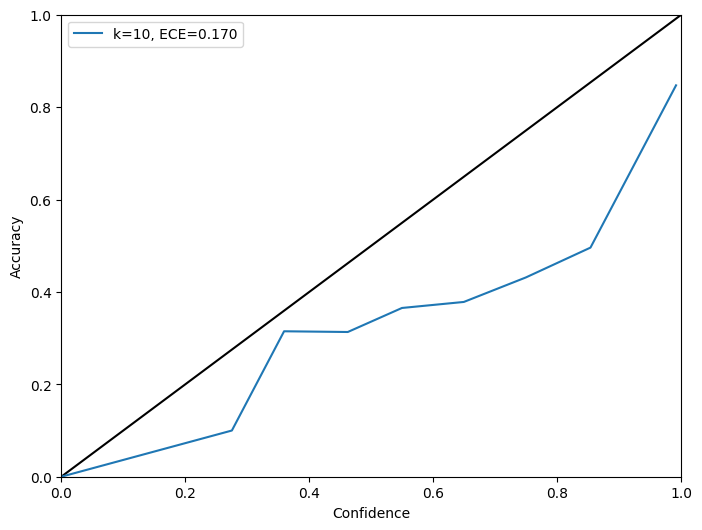

In [ ]:
training_manager.train(300, eval_mode='regular')
result_manager.save(ks=[10])

In [ ]:
config = {
    "experiment": "resnet50_300e_sd10",
    "dataset": "cifar10",  # from which we get classes separately
    "input_dim": (32, 32),
    "model": "resnet50",
    "dropout_mode": "none",
    "dropout_p": 0.0,
    "sd_mode": "constant",
    "sd_p": 0.1,
    "loss": "CE",  # ["CE", "Focal"]
    "optimizer": "sgd",
    "lr": 0.1,
    "weight_decay": 1e-4,
    "scheduler": "multistep",  # ["poly", "exp", "multistep"],
    "milestones": [150, 225],
    "gamma": 0.1,
    "T": 10,
    "batch_size": 256,
    "total_epochs": 300,
    "patience": 300,
    "track_metrics": ["loss", "acc"],
}

training_manager = TrainingManager(config, datasets)
result_manager = ResultManager(training_manager, _create_experiment_dir(config))

training_manager.train(300, eval_mode='regular')

result_manager.save(ks=[10])

created directory /content/drive/MyDrive/Bayes-Stochastic-Depth/results/cifar10/resnet50_300e_sd10


100%|██████████| 20/20 [00:00<00:00, 35.04it/s]


Epoch 1
train: Acc(g) = 10.0222, Acc(c) = 10.0211, Loss = 8.4688
val: Acc(g) = 10.1200, Acc(c) = 9.9803, Loss = 2.3014


100%|██████████| 20/20 [00:00<00:00, 34.97it/s]


Epoch 2
train: Acc(g) = 12.6733, Acc(c) = 12.6644, Loss = 3.1768
val: Acc(g) = 13.2800, Acc(c) = 13.0689, Loss = 2.2809


100%|██████████| 20/20 [00:00<00:00, 33.49it/s]


Epoch 3
train: Acc(g) = 14.6911, Acc(c) = 14.6746, Loss = 2.5808
val: Acc(g) = 14.8400, Acc(c) = 14.5504, Loss = 2.2230


 39%|███▉      | 69/176 [00:07<00:11,  9.36it/s]

created directory /content/drive/MyDrive/Bayes-Stochastic-Depth/results/cifar10/resnet50_10e_10sd


100%|██████████| 20/20 [00:00<00:00, 34.72it/s]


Epoch 1
train: Acc(g) = 12.9689, Acc(c) = 12.9599, Loss = 6.8937
val: Acc(g) = 17.8600, Acc(c) = 18.2497, Loss = 2.1611


100%|██████████| 20/20 [00:00<00:00, 35.10it/s]


Epoch 2
train: Acc(g) = 19.0133, Acc(c) = 18.9906, Loss = 2.5618
val: Acc(g) = 21.3000, Acc(c) = 21.7058, Loss = 2.0798


100%|██████████| 20/20 [00:00<00:00, 35.13it/s]


Epoch 3
train: Acc(g) = 22.9756, Acc(c) = 22.9482, Loss = 2.2341
val: Acc(g) = 21.7200, Acc(c) = 22.0544, Loss = 2.0426


100%|██████████| 20/20 [00:00<00:00, 34.48it/s]


Epoch 4
train: Acc(g) = 24.6000, Acc(c) = 24.5772, Loss = 2.0956
val: Acc(g) = 27.4200, Acc(c) = 27.5775, Loss = 1.9498


100%|██████████| 20/20 [00:00<00:00, 29.71it/s]


Epoch 5
train: Acc(g) = 27.5111, Acc(c) = 27.4954, Loss = 1.9757
val: Acc(g) = 28.0400, Acc(c) = 28.1621, Loss = 1.9161


100%|██████████| 20/20 [00:00<00:00, 33.68it/s]


Epoch 6
train: Acc(g) = 30.1422, Acc(c) = 30.1269, Loss = 1.9046
val: Acc(g) = 32.9200, Acc(c) = 32.9861, Loss = 1.8080


100%|██████████| 20/20 [00:00<00:00, 35.11it/s]


Epoch 7
train: Acc(g) = 33.7867, Acc(c) = 33.7788, Loss = 1.8227
val: Acc(g) = 36.7000, Acc(c) = 36.8719, Loss = 1.7264


100%|██████████| 20/20 [00:00<00:00, 33.53it/s]


Epoch 8
train: Acc(g) = 35.8156, Acc(c) = 35.8103, Loss = 1.7671
val: Acc(g) = 37.8800, Acc(c) = 37.8719, Loss = 1.6998


100%|██████████| 20/20 [00:00<00:00, 35.33it/s]


Epoch 9
train: Acc(g) = 38.6956, Acc(c) = 38.6889, Loss = 1.6887
val: Acc(g) = 41.9000, Acc(c) = 41.9395, Loss = 1.6075


100%|██████████| 20/20 [00:00<00:00, 35.24it/s]


Epoch 10
train: Acc(g) = 40.8244, Acc(c) = 40.8188, Loss = 1.6280
val: Acc(g) = 42.1200, Acc(c) = 42.2986, Loss = 1.5958
saved history to /content/drive/MyDrive/Bayes-Stochastic-Depth/results/cifar10/resnet50_10e_10sd/history.json
saved history to /content/drive/MyDrive/Bayes-Stochastic-Depth/results/cifar10/resnet50_10e_10sd/history.png
saved config to /content/drive/MyDrive/Bayes-Stochastic-Depth/results/cifar10/resnet50_10e_10sd/config.json
saved net to /content/drive/MyDrive/Bayes-Stochastic-Depth/results/cifar10/resnet50_10e_10sd/net.pt
Evaluating on test set...


100%|██████████| 40/40 [00:01<00:00, 35.06it/s]


saved results to /content/drive/MyDrive/Bayes-Stochastic-Depth/results/cifar10/resnet50_10e_10sd/results.json
computing calibration for k=[10]


100%|██████████| 40/40 [02:13<00:00,  3.34s/it]


saved to /content/drive/MyDrive/Bayes-Stochastic-Depth/results/cifar10/resnet50_10e_10sd/calibration.json


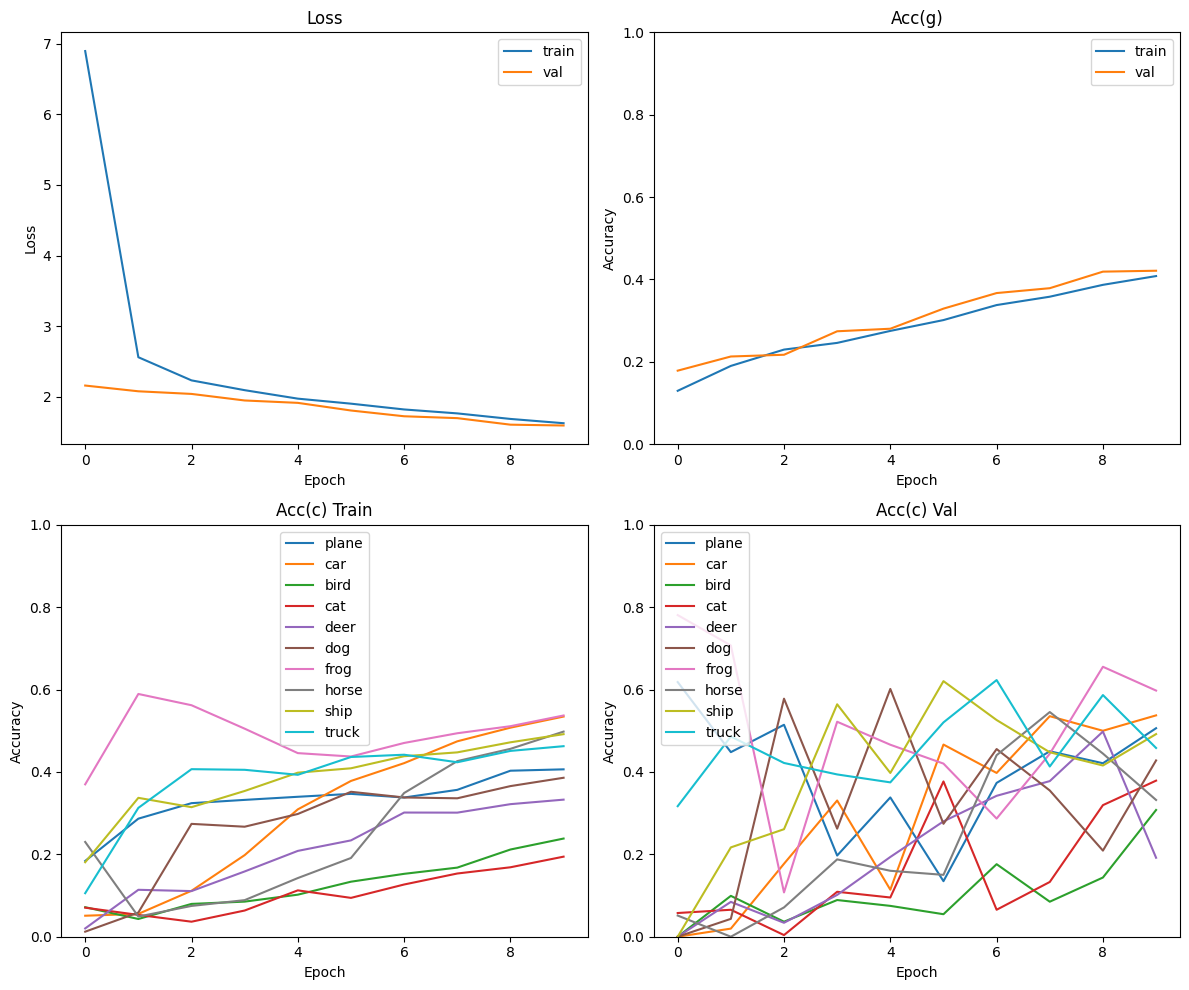

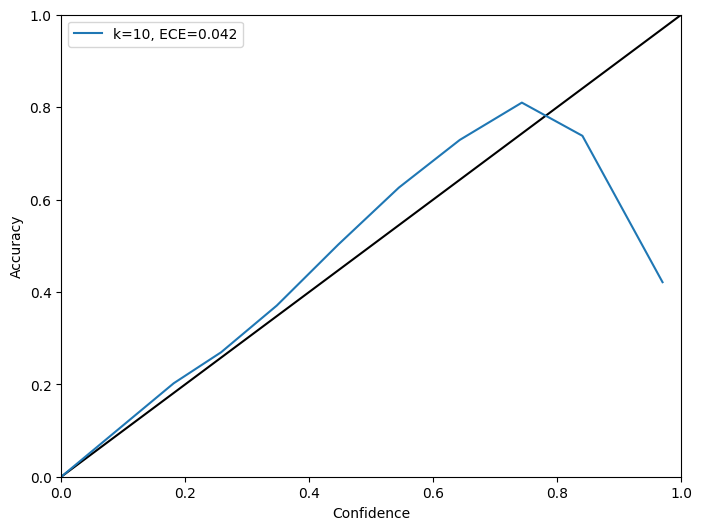

In [ ]:
config = {
    "experiment": "resnet50_10e_10sd",
    "description": "",
    "dataset": "cifar10",  # from which we get classes separately
    "input_dim": (32, 32),
    "model": "resnet50",
    "dropout_mode": "none",
    "dropout_p": 0.0,
    "sd_mode": "constant",
    "sd_p": 0.1,
    "loss": "CE",  # ["CE", "Focal"]
    "optimizer": "sgd",
    "lr": 0.1,
    "weight_decay": 1e-4,
    "scheduler": "multistep",  # ["poly", "exp", "multistep"],
    "milestones": [150, 225],
    "gamma": 0.1,
    "T": 10,
    "batch_size": 256,
    "total_epochs": 300,
    "patience": 20,
    "track_metrics": ["loss", "acc"],
}

training_manager = TrainingManager(config, datasets)
result_manager = ResultManager(training_manager, _create_experiment_dir(config))

training_manager.train(10, eval_mode='regular')

result_manager.save(ks=[10])

In [ ]:
result_manager = ResultManager(training_manager, _create_experiment_dir(config))
result_manager._save_results()

NameError: ignored